# Statistical comparison for all models studied

## Previous


Esta celda detecta si el código se ejecuta en **Google Colab** o localmente, configura rutas base para guardar datasets y modelos, y crea los directorios necesarios si no existen.


In [1]:
from pathlib import Path
import os
import IPython

def detectar_entorno_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def configurar_rutas(base_local=None, base_colab="/content/drive/MyDrive/ia_thermal_colab", verbose=True):
    IN_COLAB = detectar_entorno_colab()

    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/drive')
        base_path = Path(base_colab)
    else:
        # ⚠️ Si no se pasa base_local, usar el directorio del notebook
        if base_local is None:
            base_path = Path.cwd()
        else:
            base_path = Path(base_local).expanduser().resolve()

    datasets_path = base_path / "datasets"
    models_path = base_path / "models" / "ConvLSTM_6ch" / "stateful_O2O"
    figures_path = base_path / "figures" / "comparison_convlstm"
    datasets_path.mkdir(parents=True, exist_ok=True)
    models_path.mkdir(parents=True, exist_ok=True)
    figures_path.mkdir(parents=True, exist_ok=True)

    if verbose:
        print("✅ Entorno detectado:", "Colab" if IN_COLAB else "Local")
        print("📁 Ruta base:", base_path)
        print("📁 Ruta datasets:", datasets_path)
        print("📁 Ruta modelos:", models_path)
        print("📁 Ruta figures:", figures_path)

    return IN_COLAB, base_path, datasets_path, models_path, figures_path

# 🟢 Llamada principal
IN_COLAB, BASE_PATH, DATASETS_PATH, MODELS_PATH, FIGURES_PATH = configurar_rutas()


✅ Entorno detectado: Local
📁 Ruta base: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo
📁 Ruta datasets: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets
📁 Ruta modelos: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O
📁 Ruta figures: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\comparison_convlstm



Esta celda clona el repositorio del proyecto en Colab, instala las dependencias desde `requirements.txt` y reinicia el entorno para aplicar los cambios.

🔧 *Sugerencia*: podrías separar la clonación del repositorio y la instalación en funciones para mayor claridad y reutilización.


In [2]:
# 🔄 Parámetros del repositorio
GIT_REPO_URL = "https://github.com/dgbarcena/ia_thermal"  # 👈 Cambia si usas otro repo
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = BASE_PATH / REPO_NAME  # Usamos Path (de pathlib)

def clonar_repo_si_no_existe(repo_url: str, clone_path: Path):
    if not clone_path.exists():
        print(f"📥 Clonando repositorio en {clone_path}...")
        os.system(f"git clone {repo_url} {clone_path}")
    else:
        print(f"📂 Repositorio ya clonado en: {clone_path}")

def instalar_requirements(clone_path: Path):
    req_path = clone_path / "requirements.txt"
    if req_path.exists():
        print("📦 Instalando dependencias desde requirements.txt...")
        os.system(f"pip install -r {req_path}")
    else:
        print("⚠️ No se encontró requirements.txt en el repositorio.")

def reiniciar_entorno_colab():
    print("🔄 Reiniciando entorno para aplicar los cambios...")
    display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

# 🧪 Ejecutar solo en Colab
if IN_COLAB:
    clonar_repo_si_no_existe(GIT_REPO_URL, CLONE_PATH)
    instalar_requirements(CLONE_PATH)
    reiniciar_entorno_colab()


Se importan todas las librerías necesarias, tanto estándar como personalizadas. También se configura el path para poder importar módulos específicos según el entorno.

In [3]:
# Librerías estándar
import os, sys, time, json, platform
from datetime import datetime
from typing import Sequence, Union, Optional


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown

# NumPy y ciencia de datos
import numpy as np

# PyTorch y entrenamiento
import torch
from torch import nn, amp
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch._dynamo
from contextlib import nullcontext

# Añadir rutas del proyecto (de forma portable)
sys.path.append(str(BASE_PATH))
sys.path.append(str(BASE_PATH / "ia_thermal"))
sys.path.append(str(BASE_PATH / "ia_thermal" / "ismaelgallo"))
sys.path.append(str(BASE_PATH.parent))

# Módulos propios del proyecto
from architectures.convlstm import *
from Dataset_Class_convlstm import load_dataset_convlstm
from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *

In [4]:
# =============== CONFIGURACIÓN DE MATPLOTLIB ===============
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams["figure.figsize"] = (6,4)
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "lmroman10-regular"
plt.rcParams["font.size"] = 20
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.titlesize"] = 20


Esta celda detecta si hay una GPU disponible y selecciona `cuda` si es posible; de lo contrario, usa `cpu`. Muestra por pantalla qué dispositivo se está utilizando.

In [5]:
device = seleccionar_dispositivo(use_cuda=True)

📟 Dispositivo seleccionado: cuda



Recopila información del sistema operativo, arquitectura, procesador, versión de Python, dispositivo de cómputo y, si hay GPU disponible, también su nombre, memoria y versión de CUDA.



In [6]:
system_specs = get_system_specs(device)
system_specs

{'os': 'Windows',
 'os_version': '10.0.19041',
 'machine': 'AMD64',
 'processor': 'Intel64 Family 6 Model 158 Stepping 10, GenuineIntel',
 'python_version': '3.9.21',
 'device': 'cuda',
 'gpu_name': 'NVIDIA GeForce GTX 1050',
 'gpu_memory_total_GB': 2.0,
 'cuda_version': '11.8'}

## Auxiliar functions

Cajón desastre con las funciones requeridas para el análisis de este caso

In [7]:
np.random.seed(0)  # Para reproducibilidad

def generate_unique_cases(n_data):
    """
    Genera casos únicos evitando duplicados para asegurar diversidad en el análisis.
    
    Args:
        n_data: Número de casos únicos a generar
        
    Returns:
        Q_list: Array de potencias de heaters [W] - shape (n_data, 4)
        T_int_list: Array de temperaturas de interfaces [K] - shape (n_data, 4)  
        T_env_list: Array de temperaturas ambiente [K] - shape (n_data,)
    """
    seen = set()
    Q_list, T_int_list, T_env_list = [], [], []
    
    while len(Q_list) < n_data:
        # Generar condiciones aleatorias
        Q = tuple(np.random.uniform(0.5, 1.5, 4).round(6))        # Potencias [0.5-1.5W]
        T_int = tuple(np.random.uniform(270, 320, 4).round(2))    # Interfaces [270-320K]
        T_env = round(float(np.random.uniform(270, 320)), 2)      # Ambiente [270-320K]
        
        # Crear clave única para evitar duplicados
        key = Q + T_int + (T_env,)
        
        if key not in seen:
            seen.add(key)
            Q_list.append(Q)
            T_int_list.append(T_int)
            T_env_list.append(T_env)
    
    return np.array(Q_list), np.array(T_int_list), np.array(T_env_list)

In [8]:
def load_model_by_hyperparameters(models_path, n_train=None, time_sim=None, dt=None, 
                                 batch_sizes=None, hidden_dims=None, kernel_size=None,
                                 device='cpu', verbose=True, exclude_physics=True, 
                                 physics_keywords=None, exclude_keywords=None,
                                 load_configs=True):
    """
    Función para cargar modelos automáticamente basándose en hiperparámetros específicos.
    
    Args:
        models_path: Path donde están guardados los modelos
        n_train: número de datos de entrenamiento (int/list: ej: 1000 o [250, 500, 1000])
        time_sim: tiempo de simulación (int/list: ej: 50 o [50, 100])
        dt: delta tiempo (int/list: ej: 1 o [1, 2])
        batch_sizes: lista de batch sizes a buscar (list: ej: [16, 32, 64])
        hidden_dims: dimensiones ocultas (list/list of lists: ej: [64, 64] o [[32,32], [64,64]])
        kernel_size: tamaño del kernel (tuple/list: ej: (3,3) o [(3,3), (5,5)])
        device: dispositivo donde cargar el modelo
        verbose: mostrar información de carga
        exclude_physics: si True, excluye modelos con implementación de física
        physics_keywords: lista de palabras clave que indican modelos con física
        exclude_keywords: lista adicional de palabras clave a excluir
        load_configs: si True, carga también los archivos JSON de configuración
        
    Returns:
        dict: diccionario con los modelos cargados {nombre_modelo: modelo}
        dict: diccionario con las configuraciones JSON {nombre_modelo: config} (si load_configs=True)
    """
    
    # Palabras clave por defecto para modelos con física
    if physics_keywords is None:
        physics_keywords = ['phy', 'bnd', 'mse']
    
    # Palabras clave adicionales a excluir
    if exclude_keywords is None:
        exclude_keywords = []
    
    # Combinar todas las palabras clave a excluir
    all_exclude_keywords = []
    if exclude_physics:
        all_exclude_keywords.extend(physics_keywords)
    all_exclude_keywords.extend(exclude_keywords)
    
    # 🔧 NORMALIZAR TODOS LOS HIPERPARÁMETROS A LISTAS
    def normalize_to_list(param, param_name):
        """Convierte parámetro a lista, maneja None como 'todos los valores'"""
        if param is None:
            return [None]  # Indica que debe buscar todos los valores
        elif isinstance(param, (list, tuple)):
            return list(param)
        else:
            return [param]
    
    n_train_list = normalize_to_list(n_train, 'n_train')
    time_sim_list = normalize_to_list(time_sim, 'time_sim')
    dt_list = normalize_to_list(dt, 'dt')
    batch_sizes_list = normalize_to_list(batch_sizes, 'batch_sizes')
    
    # Para hidden_dims, manejar casos especiales
    if hidden_dims is None:
        hidden_dims_list = [None]
    elif isinstance(hidden_dims[0], (list, tuple)):
        # Es una lista de listas: [[32,32], [64,64]]
        hidden_dims_list = hidden_dims
    else:
        # Es una lista simple: [64, 64]
        hidden_dims_list = [hidden_dims]
    
    # Para kernel_size, manejar casos especiales
    if kernel_size is None:
        kernel_size_list = [None]
    elif isinstance(kernel_size, tuple):
        # Es una tupla simple: (3,3)
        kernel_size_list = [kernel_size]
    elif isinstance(kernel_size[0], tuple):
        # Es una lista de tuplas: [(3,3), (5,5)]
        kernel_size_list = kernel_size
    else:
        # Es una lista de listas: [[3,3], [5,5]]
        kernel_size_list = [tuple(ks) for ks in kernel_size]
    
    # 🔧 GENERAR TODAS LAS COMBINACIONES DE PATRONES
    search_patterns = []
    
    for nt in n_train_list:
        for ts in time_sim_list:
            for dt_val in dt_list:
                for hd in hidden_dims_list:
                    for ks in kernel_size_list:
                        for bs in batch_sizes_list:
                            
                            # Construir patrón base
                            pattern = "PCB_ConvLSTM_6ch"
                            
                            # Agregar n_train (solo si no es None)
                            if nt is not None:
                                pattern += f"_nt{nt}"
                            
                            # Agregar time_sim (solo si no es None)
                            if ts is not None:
                                pattern += f"_{ts}s"
                            
                            # Agregar dt (solo si no es None)
                            if dt_val is not None:
                                pattern += f"_dt{dt_val}"
                            
                            # Agregar batch_size (solo si no es None)
                            if bs is not None:
                                pattern += f"_bs{bs}"
                            
                            # Agregar hidden_dims (solo si no es None)
                            if hd is not None:
                                layer_string = "-".join(str(d) for d in hd)
                                pattern += f"_h{layer_string}"
                            
                            # Agregar kernel_size (solo si no es None)
                            if ks is not None:
                                kernel_string = f"{ks[0]}x{ks[1]}"
                                pattern += f"_k{kernel_string}"
                            
                            search_patterns.append(pattern)
    
    # Eliminar patrones duplicados
    search_patterns = list(set(search_patterns))
    
    if verbose:
        print(f"🔍 Buscando modelos con patrones:")
        for pattern in search_patterns[:10]:  # Mostrar solo los primeros 10
            print(f"   📝 {pattern}")
        if len(search_patterns) > 10:
            print(f"   ... y {len(search_patterns) - 10} patrones más")
        
        if exclude_physics:
            print(f"🚫 Excluyendo modelos con palabras clave de física: {physics_keywords}")
        if exclude_keywords:
            print(f"🚫 Excluyendo modelos con palabras clave adicionales: {exclude_keywords}")
        if load_configs:
            print(f"📋 Cargando también archivos JSON de configuración")
    
    # 🔧 BÚSQUEDA INTELIGENTE DE ARCHIVOS
    loaded_models = {}
    loaded_configs = {}
    excluded_files = []
    models_path = Path(models_path)
    
    # Obtener todos los archivos .pth disponibles
    all_pth_files = list(models_path.glob("*.pth"))
    
    for pattern in search_patterns:
        # Si el patrón contiene None (wildcards), usar búsqueda especial
        if pattern == "PCB_ConvLSTM_6ch":
            # Patrón completamente genérico, buscar todos los archivos
            matching_files = all_pth_files
        else:
            # Búsqueda específica por patrón
            matching_files = []
            
            for pth_file in all_pth_files:
                filename = pth_file.name
                
                # Si hay Nones en los parámetros, usar matching flexible
                if any(param is None for param in [nt, ts, dt_val, bs, hd, ks] 
                       for nt in n_train_list for ts in time_sim_list 
                       for dt_val in dt_list for bs in batch_sizes_list 
                       for hd in hidden_dims_list for ks in kernel_size_list):
                    
                    # Matching flexible: verificar que las partes especificadas estén presentes
                    pattern_parts = pattern.replace("PCB_ConvLSTM_6ch_", "").split("_")
                    pattern_parts = [part for part in pattern_parts if part]  # Remover vacíos
                    
                    if all(part in filename for part in pattern_parts):
                        matching_files.append(pth_file)
                else:
                    # Matching exacto
                    if pattern in filename:
                        matching_files.append(pth_file)
        
        # Procesar archivos encontrados
        for model_file in matching_files:
            filename = model_file.stem.lower()  # Convertir a minúsculas para comparación
            
            # Verificar si ya fue procesado
            model_name = model_file.stem.replace("PCB_ConvLSTM_6ch_", "")
            if model_name in loaded_models:
                continue
            
            # Verificar si el archivo contiene palabras clave a excluir
            should_exclude = False
            excluded_reason = ""
            
            for keyword in all_exclude_keywords:
                if keyword.lower() in filename:
                    should_exclude = True
                    excluded_reason = f"contiene '{keyword}'"
                    break
            
            if should_exclude:
                excluded_files.append((model_file.name, excluded_reason))
                if verbose:
                    print(f"🚫 Excluido: {model_file.name} ({excluded_reason})")
                continue
            
            try:
                # Extraer hiperparámetros del nombre del archivo para crear el modelo
                filename_original = model_file.stem
                
                # Extraer hidden_dims del nombre
                if "_h" in filename_original:
                    h_part = filename_original.split("_h")[1].split("_")[0]
                    model_hidden_dims = [int(x) for x in h_part.split("-")]
                else:
                    model_hidden_dims = hidden_dims_def
                
                # Extraer kernel_size del nombre  
                if "_k" in filename_original:
                    k_part = filename_original.split("_k")[1].split("_")[0]
                    k_size = tuple(map(int, k_part.split("x")))
                    model_kernel_size = [(k_size)] * len(model_hidden_dims)
                else:
                    model_kernel_size = kernel_size_def
                
                # Crear la arquitectura del modelo
                model = PCB_ConvLSTM(
                    input_channels=6,
                    hidden_dims=model_hidden_dims,
                    kernel_size=model_kernel_size,
                    height=13,
                    width=13
                )
                
                # Cargar los pesos
                checkpoint = torch.load(model_file, map_location=device)
                
                # Manejar diferentes formatos de checkpoint
                if isinstance(checkpoint, dict):
                    if 'model_state_dict' in checkpoint:
                        model.load_state_dict(checkpoint['model_state_dict'])
                    elif 'state_dict' in checkpoint:
                        model.load_state_dict(checkpoint['state_dict'])
                    else:
                        # Asumir que el checkpoint completo es el state_dict
                        model.load_state_dict(checkpoint)
                else:
                    model.load_state_dict(checkpoint)
                
                model.to(device)
                model.eval()
                
                # Crear nombre descriptivo para el modelo
                loaded_models[model_name] = model
                
                # Cargar archivo JSON de configuración si existe
                config_loaded = False
                if load_configs:
                    # Buscar archivo JSON con el mismo nombre base
                    json_file = model_file.with_suffix('.json')
                    if json_file.exists():
                        try:
                            with open(json_file, 'r', encoding='utf-8') as f:
                                config = json.load(f)
                            loaded_configs[model_name] = config
                            config_loaded = True
                            if verbose:
                                print(f"   📋 Config cargado: {json_file.name}")
                        except Exception as e:
                            if verbose:
                                print(f"   ⚠️ Error cargando config {json_file.name}: {str(e)}")
                    else:
                        if verbose:
                            print(f"   📋 No se encontró config para: {model_file.name}")
                
                if verbose:
                    print(f"✅ Cargado: {model_name}")
                    print(f"   📁 Archivo: {model_file.name}")
                    print(f"   🧠 Hidden dims: {model_hidden_dims}")
                    print(f"   🔲 Kernel size: {model_kernel_size[0]}")
                    if load_configs:
                        print(f"   📋 Config: {'✅' if config_loaded else '❌'}")
                
            except Exception as e:
                if verbose:
                    print(f"❌ Error cargando {model_file.name}: {str(e)}")
                continue
    
    if not loaded_models:
        print("⚠️ No se encontraron modelos que coincidan con los criterios especificados.")
        print(f"📂 Buscando en: {models_path}")
        print(f"🔍 Patrones buscados: {search_patterns[:5]}...")  # Mostrar solo algunos
        
        # Mostrar archivos disponibles
        available_files = list(models_path.glob("*.pth"))
        if available_files:
            print(f"\n📋 Archivos disponibles en {models_path}:")
            for f in available_files[:10]:  # Mostrar solo los primeros 10
                print(f"   📄 {f.name}")
            if len(available_files) > 10:
                print(f"   ... y {len(available_files) - 10} más")
    
    if verbose and excluded_files:
        print(f"\n📋 Resumen de archivos excluidos:")
        for filename, reason in excluded_files:
            print(f"   🚫 {filename} - {reason}")
    
    if load_configs:
        if verbose:
            print(f"\n📊 Resumen de carga:")
            print(f"   🤖 Modelos cargados: {len(loaded_models)}")
            print(f"   📋 Configs cargados: {len(loaded_configs)}")
        return loaded_models, loaded_configs
    else:
        return loaded_models


# Función actualizada para cargar solo modelos sin física (con configs)
def load_batch_size_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de batch sizes (sin física)."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                           # Fijo
        time_sim=50,                           # Fijo
        dt=1,                                  # Fijo
        batch_sizes=[8, 16, 32, 64, 128, 256], # Variable
        hidden_dims=[64, 64],                  # Fijo
        kernel_size=(3, 3),                    # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_training_cases_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de training cases."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=[100, 250, 500, 1000, 2000, 4000],  # Variable
        time_sim=50,                                 # Fijo
        dt=1,                                        # Fijo
        batch_sizes=16,                              # Fijo
        hidden_dims=[64, 64],                        # Fijo
        kernel_size=(3, 3),                          # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_architecture_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de arquitecturas."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                               # Fijo
        time_sim=50,                                # Fijo
        dt=1,                                       # Fijo
        batch_sizes=16,                             # Fijo
        hidden_dims=[[32, 32], [64, 64], [128, 128]], # Variable
        kernel_size=[(3, 3), (5, 5)],              # Variable
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_time_simulation_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de tiempos de simulación."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                    # Fijo
        time_sim=[50, 100, 200, 500],    # Variable
        dt=1,                            # Fijo
        batch_sizes=16,                  # Fijo
        hidden_dims=[64, 64],            # Fijo
        kernel_size=(3, 3),              # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_all_models_wildcard(models_path, device='cpu', load_configs=True):
    """Carga TODOS los modelos disponibles (usando wildcards)."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=None,        # Todos los valores
        time_sim=None,       # Todos los valores
        dt=None,             # Todos los valores
        batch_sizes=None,    # Todos los valores
        hidden_dims=None,    # Todos los valores
        kernel_size=None,    # Todos los valores
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_physics_models_comparison(models_path, device='cpu', load_configs=True):
    """Carga específicamente modelos con implementación de física."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=False,  # NO excluir modelos con física
        exclude_keywords=[],    # Lista vacía
        load_configs=load_configs,
        verbose=True
    )


# Función para cargar solo modelos con física (con configs)
def load_physics_models(models_path, device='cpu', load_configs=True):
    """
    Carga específicamente modelos con implementación de física.
    """
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=False,  # No excluir modelos con física
        exclude_keywords=[],    # Lista vacía para no excluir nada adicional
        load_configs=load_configs,
        verbose=True
    )


# Función para cargar modelos con palabras clave específicas a excluir (con configs)
def load_custom_filtered_models(models_path, exclude_keywords_custom=None, device='cpu', load_configs=True):
    """
    Carga modelos con filtros personalizados.
    """
    if exclude_keywords_custom is None:
        exclude_keywords_custom = []
        
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=True,
        exclude_keywords=exclude_keywords_custom,  # Palabras clave adicionales a excluir
        load_configs=load_configs,
        verbose=True
    )

In [ ]:
def calculate_convlstm_error_by_timestep(model, dataset, T_transient_all, Q_cases, 
                                        T_interfaces_cases, T_env_cases, dt=1, device=None, 
                                        sequence_length=None, display=True):
    """
    Calculates the ConvLSTM error per time step comparing ConvLSTM predictions 
    with solver solutions using the autoregressive process.
    
    Parameters:
        model: trained ConvLSTM model
        dataset: PCBDataset_convlstm object
        T_transient_all: array (n_cases, time_steps, 169) with solver solutions
        Q_cases: array (n_cases, 4) with heater powers
        T_interfaces_cases: array (n_cases, 4) with interface temperatures  
        T_env_cases: array (n_cases,) with environment temperatures
        dt: time step value in seconds (default: 1)
        device: computation device
        sequence_length: sequence length for model input (if None, uses T_transient_all.shape[1])
        display: whether to show progress information
        
    Returns:
        dict with error statistics per timestep
    """
    
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    H, W = 13, 13
    
    # Verify spatial nodes
    if spatial_nodes != H * W:
        raise ValueError(f"Expected {H*W} spatial nodes, got {spatial_nodes}")
    
    if sequence_length is None:
        sequence_length = time_steps
    elif sequence_length > time_steps:
        raise ValueError(f"sequence_length ({sequence_length}) cannot be larger than available time steps ({time_steps})")
    
    if display:
        print(f"🔄 Calculating ConvLSTM error by timestep (autoregressive)")
        print(f"   📊 Cases: {n_cases}")
        print(f"   ⏱️ Time steps: {time_steps}")
        print(f"   ⏱️ dt: {dt}s")
        print(f"   🔗 Sequence length: {sequence_length}")
        print(f"   🌐 Spatial nodes: {spatial_nodes} ({H}x{W})")
    
    # Storage for errors per timestep
    mae_per_timestep = np.zeros(sequence_length)
    mse_per_timestep = np.zeros(sequence_length)
    rmse_per_timestep = np.zeros(sequence_length)
    std_per_timestep = np.zeros(sequence_length)
    max_per_timestep = np.zeros(sequence_length)
    min_per_timestep = np.zeros(sequence_length)
    
    # Storage for all predictions and errors
    all_predictions = np.zeros((n_cases, sequence_length, H, W))
    all_errors = np.zeros((n_cases, sequence_length, H, W))
    
    # Process each case
    for i in tqdm(range(n_cases), desc="Processing cases", disable=not display):
        # Get conditions for this case
        Q = Q_cases[i]
        T_int = T_interfaces_cases[i] 
        T_env = T_env_cases[i]
        
        # Get solver solution (ground truth) and reshape to (time_steps, H, W)
        T_true_flat = T_transient_all[i, :sequence_length]  # (time_steps, 169)
        T_true = T_true_flat.reshape(sequence_length, H, W)  # (time_steps, H, W)
        
        # =============== CONVLSTM AUTOREGRESSIVE PREDICTION ===============
        # Use initial temperature from solver
        T_seq_initial = T_true[0]  # Use first timestep from solver as initial condition
        
        # 1) Primer input (1,1,6,13,13)
        input0 = dataset.create_input_from_values(
            Q, T_int, T_env,
            T_seq=np.expand_dims(T_seq_initial, 0),
            sequence_length=sequence_length,
            autorregress=True
        ).to(device)

        # 2) Prepara contornos y t_prev
        # bc_static: (1, seq_len, 5, 13,13)
        bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
        # t_prev: (1,1,1,13,13)
        t_prev = input0[:, :1, 5:6, :, :]

        # 3) Roll-out autoregresivo
        preds_norm = []
        hidden = None
        with torch.no_grad():
            for t in range(sequence_length):
                # concatenar por canal (dim=2)
                x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
                pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
                t_prev = pred_t                                        # mantener shape
                preds_norm.append(t_prev)

        preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

        # 4) Desnormalizar
        mean = dataset.T_outputs_mean.to(device)
        std_dev = dataset.T_outputs_std.to(device)
        preds_denorm = preds_norm * std_dev + mean      # (1, T, 1, H, W)
        T_pred = preds_denorm.squeeze(0).squeeze(1).cpu().numpy()  # (T, 13, 13)
        
        # Store predictions
        all_predictions[i] = T_pred
        
        # Calculate errors for this case
        case_errors = np.abs(T_true - T_pred)  # Absolute error (time_steps, H, W)
        all_errors[i] = case_errors
    
    # Calculate statistics across all cases for each timestep
    for t in range(sequence_length):
        errors_t = all_errors[:, t, :, :]  # (n_cases, H, W)
        
        # Flatten spatial dimensions for statistics
        errors_flat = errors_t.flatten()  # (n_cases * H * W,)
        
        mae_per_timestep[t] = np.mean(errors_flat)
        mse_per_timestep[t] = np.mean(errors_flat**2)
        rmse_per_timestep[t] = np.sqrt(mse_per_timestep[t])
        std_per_timestep[t] = np.std(errors_flat)
        max_per_timestep[t] = np.max(errors_flat)
        min_per_timestep[t] = np.min(errors_flat)
    
    # Calculate overall statistics
    overall_mae = np.mean(mae_per_timestep)
    overall_rmse = np.mean(rmse_per_timestep)
    overall_std = np.mean(std_per_timestep)
    
    # Create time array based on dt (CAMBIO PRINCIPAL)
    time_array = np.arange(sequence_length) * dt  # Ahora en segundos reales
    
    if display:
        print(f"\n📊 CONVLSTM ERROR ANALYSIS RESULTS:")
        print(f"   Overall MAE: {overall_mae:.3f} K")
        print(f"   Overall RMSE: {overall_rmse:.3f} K") 
        print(f"   Overall STD: {overall_std:.3f} K")
        print(f"   Initial timestep MAE: {mae_per_timestep[0]:.3f} K")
        print(f"   Final timestep MAE: {mae_per_timestep[-1]:.3f} K")
        print(f"   Maximum timestep error: {np.max(mae_per_timestep):.3f} K at t={np.argmax(mae_per_timestep)*dt:.1f}s")
        print(f"   Time range: [{time_array[0]:.1f}s, {time_array[-1]:.1f}s]")
    
    # Prepare results dictionary (same format as other models)
    results = {
        # Error statistics per timestep
        'time_array': time_array,  # Ahora en segundos reales
        'mae_per_timestep': mae_per_timestep,
        'mse_per_timestep': mse_per_timestep,
        'rmse_per_timestep': rmse_per_timestep,
        'std_per_timestep': std_per_timestep,
        'max_per_timestep': max_per_timestep,
        'min_per_timestep': min_per_timestep,
        
        # Overall statistics
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse,
        'overall_std': overall_std,
        
        # Complete arrays (reshaped to spatial format for analysis)
        'all_predictions': all_predictions,    # (n_cases, time_steps, H, W)
        'all_errors': all_errors,              # (n_cases, time_steps, H, W)
        'T_true_reshaped': T_transient_all[:, :sequence_length].reshape(n_cases, sequence_length, H, W),  # (n_cases, time_steps, H, W)
        
        # Original flat format
        'T_true_flat': T_transient_all[:, :sequence_length],  # (n_cases, time_steps, 169)
        
        # Metadata
        'n_cases': n_cases,
        'sequence_length': sequence_length,
        'spatial_nodes': spatial_nodes,
        'spatial_shape': (H, W),
        'dt': dt  # Añadido para referencia
    }
    
    return results



def plot_error_with_std_bands(results, save_as_pdf=False, filename='error_with_std_bands'):
    """
    Plots average error over time with standard deviation bands.
    
    Parameters:
        results: results dictionary from calculate_network_error_by_timestep
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    time_array = results['time_array']
    mae_per_timestep = results['mae_per_timestep']
    std_per_timestep = results['std_per_timestep']
    
    # Calculate upper and lower bounds for std bands
    upper_bound = mae_per_timestep + std_per_timestep
    lower_bound = mae_per_timestep - std_per_timestep
    
    # Ensure lower bound is not negative
    lower_bound = np.maximum(lower_bound, 0)
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot the standard deviation bands
    ax.fill_between(time_array, lower_bound, upper_bound, 
                    alpha=0.3, color='#1f77b4', label='Mean ± Std Dev')
    
    # Plot the mean error line
    ax.plot(time_array, mae_per_timestep, label='Mean Absolute Error', 
            linewidth=2, color='#1f77b4')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization (will be removed when saving PDF)
    title_handle = ax.set_title('Network Error Evolution with Standard Deviation', color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(0, np.max(upper_bound) * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()


def plot_error_range_per_timestep(results, save_as_pdf=False, filename='error_range_per_timestep'):
    """
    Plots error range (min-max) with mean error line for each timestep.
    This is the separated "Error Range per Timestep" plot.
    
    Parameters:
        results: results dictionary from calculate_network_error_by_timestep
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    time_array = results['time_array']
    mae_per_timestep = results['mae_per_timestep']
    min_per_timestep = results['min_per_timestep']
    max_per_timestep = results['max_per_timestep']
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot the min-max range as filled area
    ax.fill_between(time_array, min_per_timestep, max_per_timestep, 
                    alpha=0.3, color='#d62728', label='Min-Max Range')
    
    # Plot the mean error line
    ax.plot(time_array, mae_per_timestep, label='Mean Absolute Error', 
            linewidth=2, color='#1f77b4')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization (will be removed when saving PDF)
    title_handle = ax.set_title('Error Range per Timestep', color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(0, np.max(max_per_timestep) * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()


def compare_models_error_by_timestep(models_dict, dataset, T_transient_all, Q_cases, 
                                   T_interfaces_cases, T_env_cases, device=None,
                                   sequence_length=None, save_as_pdf=False, 
                                   filename='models_error_comparison_timestep'):
    """
    Compares multiple models' error evolution over timesteps.
    
    Parameters:
        models_dict: dict with model_name: model pairs
        dataset: dataset object for normalization/denormalization
        T_transient_all: array (n_cases, time_steps, 169) with solver solutions
        Q_cases, T_interfaces_cases, T_env_cases: condition arrays
        device: computation device
        sequence_length: sequence length for model input
        save_as_pdf: if True, saves the figure as PDF
        filename: base filename (without extension)
        
    Returns:
        dict with results for each model
    """
    
    comparison_results = {}
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    
    print(f"🔄 Comparing {len(models_dict)} models error by timestep")
    print(f"   📊 Data shape: {T_transient_all.shape}")
    print(f"   🌐 Spatial nodes: {spatial_nodes}")
    
    # Calculate errors for each model
    for model_name, model in models_dict.items():
        print(f"\n🤖 Analyzing {model_name}...")
        
        results = calculate_network_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_transient_all,
            Q_cases=Q_cases,
            T_interfaces_cases=T_interfaces_cases,
            T_env_cases=T_env_cases,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    # Plot comparison
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Get time array (should be same for all models)
    time_array = list(comparison_results.values())[0]['time_array']
    
    for i, (model_name, results) in enumerate(comparison_results.items()):
        color = colors[i % len(colors)]
        
        # MAE comparison
        ax1.set_facecolor('white')
        ax1.plot(time_array, results['mae_per_timestep'], label=model_name, 
                linewidth=2, color=color)
        
        # RMSE comparison  
        ax2.set_facecolor('white')
        ax2.plot(time_array, results['rmse_per_timestep'], label=model_name,
                linewidth=2, color=color)
        
        # STD comparison
        ax3.set_facecolor('white') 
        ax3.plot(time_array, results['std_per_timestep'], label=model_name,
                linewidth=2, color=color)
        
        # Max error comparison
        ax4.set_facecolor('white')
        ax4.plot(time_array, results['max_per_timestep'], label=model_name,
                linewidth=2, color=color)
    
    # Configure subplots
    titles = ['Mean Absolute Error', 'Root Mean Square Error', 
             'Standard Deviation', 'Maximum Error']
    ylabels = ['MAE [K]', 'RMSE [K]', 'STD [K]', 'Max Error [K]']
    
    for ax, title, ylabel in zip([ax1, ax2, ax3, ax4], titles, ylabels):
        ax.set_ylabel(ylabel, color='black')
        ax.set_title(title, color='black')
        ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
        ax.legend()
        ax.tick_params(colors='black')
        ax.set_xlim(time_array[0], time_array[-1])
    
    # Set x-labels for bottom plots
    ax3.set_xlabel('Time Step', color='black')
    ax4.set_xlabel('Time Step', color='black')
    
    # Main title only for visualization
    title_handle = fig.suptitle('Models Error Comparison by Timestep', 
                               fontsize=16, color='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()
    
    # Print summary
    print(f"\n🏆 MODELS COMPARISON SUMMARY:")
    print("="*70)
    print(f"{'Model':<20} {'Overall MAE':<12} {'Overall RMSE':<12} {'Final MAE':<12}")
    print("-"*70)
    
    for model_name, results in comparison_results.items():
        print(f"{model_name:<20} {results['overall_mae']:<12.3f} "
              f"{results['overall_rmse']:<12.3f} {results['mae_per_timestep'][-1]:<12.3f}")
    
    return comparison_results


def plot_models_comparison_with_std_bands(comparison_results, save_as_pdf=False, 
                                        filename='models_comparison_with_std_bands'):
    """
    Plots comparison of multiple models with error and standard deviation bands.
    Handles models with different time steps by using their respective time arrays.
    
    Parameters:
        comparison_results: dict with model_name: results pairs
                           Each results dict should contain 'time_array', 'mae_per_timestep', 'std_per_timestep'
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Colors for different models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']
    
    # Variables para calcular límites globales
    global_time_min = float('inf')
    global_time_max = float('-inf')
    global_error_max = 0
    
    # Plotear cada modelo con su propio time_array
    for i, (model_name, results) in enumerate(comparison_results.items()):
        color = colors[i % len(colors)]
        
        # Obtener arrays específicos para este modelo
        time_array = results['time_array']
        mae_per_timestep = results['mae_per_timestep']
        std_per_timestep = results['std_per_timestep']
        
        # Actualizar límites globales
        global_time_min = min(global_time_min, np.min(time_array))
        global_time_max = max(global_time_max, np.max(time_array))
        
        # Calculate bounds
        upper_bound = mae_per_timestep + std_per_timestep
        lower_bound = np.maximum(mae_per_timestep - std_per_timestep, 0)
        
        # Actualizar error máximo global
        global_error_max = max(global_error_max, np.max(upper_bound))
        
        # Determinar dt para el label
        if len(time_array) > 1:
            dt = time_array[1] - time_array[0]
            model_label = f'{model_name}'
        else:
            model_label = model_name
        
        # Plot std deviation bands
        ax.fill_between(time_array, lower_bound, upper_bound, 
                        alpha=0.2, color=color, 
                        label=f'{model_label} ± Std Dev')
        
        # Plot mean error line
        ax.plot(time_array, mae_per_timestep, 
                linewidth=2, color=color, 
                label=f'{model_label} Mean Error',
                # marker='o', markersize=3, markevery=max(1, len(time_array)//20)
                )
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization
    title_handle = ax.set_title('Models Comparison: Error Evolution with Different Time Steps', 
                               color='black')
    
    # Set axis limits usando los valores globales
    ax.set_xlim(global_time_min, global_time_max)
    ax.set_ylim(0, global_error_max * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(colors='black')
    
    # Añadir información adicional en el plot
    # info_text = f"Time range: {global_time_min:.2f}s - {global_time_max:.2f}s\n"
    # info_text += f"Models compared: {len(comparison_results)}"
    # ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
    #         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', bbox_inches='tight', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()
    
    # Imprimir información de resumen
    print("\n📊 Summary of plotted models:")
    for model_name, results in comparison_results.items():
        time_array = results['time_array']
        dt = time_array[1] - time_array[0] if len(time_array) > 1 else 0
        print(f"   - {model_name}: {len(time_array)} time steps, dt={dt:.4f}s, range=[{time_array[0]:.2f}, {time_array[-1]:.2f}]s")
        
        
def plot_physics_models_comparison_with_std_bands(comparison_results, plot_std=False, save_as_pdf=False, 
                                                 filename='physics_models_comparison_with_std_bands'):
    """
    Plots comparison of multiple physics-informed models with optional error and standard deviation bands.
    Specifically designed for models with different physics loss weights (MSE, PHY, BND).
    
    Parameters:
        comparison_results: dict with model_name: results pairs
                           Model names should be like 'MSE=1.0, PHY=0.0, BND=0.0'
        plot_std: bool, default False. If True, plots standard deviation bands
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(16, 8))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Enhanced color palette for physics models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']
    
    # Line styles for better differentiation
    line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
    
    # Variables para calcular límites globales
    global_time_min = float('inf')
    global_time_max = float('-inf')
    global_error_max = 0
    
    # Separar modelos por tipo para mejor organización
    model_categories = {
        'MSE_only': [],      # Solo MSE (MSE=1.0, PHY=0.0, BND=0.0)
        'MSE_PHY': [],       # MSE + Physics (MSE=1.0, PHY>0, BND=0.0)
        'MSE_BND': [],       # MSE + Boundary (MSE=1.0, PHY=0.0, BND>0)
        'MSE_PHY_BND': [],   # MSE + Physics + Boundary (MSE=1.0, PHY>0, BND>0)
        'PHY_BND': [],       # Solo Physics + Boundary (MSE=0.0, PHY>0, BND>0)
        'Other': []          # Otros
    }
    
    # Categorizar modelos basándose en los pesos exactos del formato generado
    for model_name, results in comparison_results.items():
        # Extraer valores usando el formato exacto: 'MSE=1.0, PHY=0.0, BND=0.0'
        mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
        
        if mse_val == 0.0 and phy_val > 0.0 and bnd_val > 0.0:
            model_categories['PHY_BND'].append((model_name, results))
        elif mse_val > 0.0 and phy_val == 0.0 and bnd_val == 0.0:
            model_categories['MSE_only'].append((model_name, results))
        elif mse_val > 0.0 and phy_val > 0.0 and bnd_val == 0.0:
            model_categories['MSE_PHY'].append((model_name, results))
        elif mse_val > 0.0 and phy_val == 0.0 and bnd_val > 0.0:
            model_categories['MSE_BND'].append((model_name, results))
        elif mse_val > 0.0 and phy_val > 0.0 and bnd_val > 0.0:
            model_categories['MSE_PHY_BND'].append((model_name, results))
        else:
            model_categories['Other'].append((model_name, results))
    
    # Plotear cada modelo con estilo específico según categoría
    plot_index = 0
    
    for category, models in model_categories.items():
        if not models:  # Skip empty categories
            continue
            
        for model_name, results in models:
            color = colors[plot_index % len(colors)]
            line_style = line_styles[plot_index % len(line_styles)]
            
            # Obtener arrays específicos para este modelo
            time_array = results['time_array']
            mae_per_timestep = results['mae_per_timestep']
            std_per_timestep = results['std_per_timestep']
            
            # Actualizar límites globales
            global_time_min = min(global_time_min, np.min(time_array))
            global_time_max = max(global_time_max, np.max(time_array))
            
            # Calculate bounds para determinar límites del gráfico
            if plot_std:
                upper_bound = mae_per_timestep + std_per_timestep
                global_error_max = max(global_error_max, np.max(upper_bound))
                
                # Plot std deviation bands solo si plot_std=True
                lower_bound = np.maximum(mae_per_timestep - std_per_timestep, 0)
                ax.fill_between(time_array, lower_bound, upper_bound, 
                                alpha=0.15, color=color)
            else:
                # Si no se plotea std, usar solo MAE para límites
                global_error_max = max(global_error_max, np.max(mae_per_timestep))
            
            # Usar el nombre exacto como se genera en tu código
            clean_label = model_name  # Mantener formato original
            
            # Plot mean error line with specific style
            ax.plot(time_array, mae_per_timestep, 
                    linewidth=2.5, color=color, linestyle=line_style,
                    label=clean_label,
                    marker='o', markersize=2, markevery=max(1, len(time_array)//25))
            
            plot_index += 1
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black', fontsize=14)
    ax.set_ylabel('Error [K]', color='black', fontsize=14)
    
    # Title con indicación de si se muestra std
    std_text = " with Std Dev Bands" if plot_std else ""
    title_handle = ax.set_title(f'Physics-Informed Models Comparison: Error Evolution with Different Loss Weights{std_text}', 
                               color='black', fontsize=16)
    
    # Set axis limits
    ax.set_xlim(global_time_min, global_time_max)
    ax.set_ylim(0, global_error_max * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    
    # Crear leyenda en dos columnas si hay muchos modelos
    ncol = 2 if len(comparison_results) > 6 else 1
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=ncol, fontsize=9)
    ax.tick_params(colors='black')
    
    # Añadir información de resumen en el plot
    info_text = f"Models compared: {len(comparison_results)}\n"
    info_text += f"Time range: [{global_time_min:.1f}s, {global_time_max:.1f}s]\n"
    info_text += f"Std Dev: {'Shown' if plot_std else 'Hidden'}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        # Ajustar nombre del archivo según si incluye std
        std_suffix = "_with_std" if plot_std else "_no_std"
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}{std_suffix}.pdf', format='pdf', 
                   bbox_inches='tight', facecolor='white', dpi=300)
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()
    
    # Imprimir lista ordenada de modelos de menor a mayor mean error
    print_physics_models_ranking(comparison_results)


def extract_physics_weights(model_name):
    """
    Extrae los pesos de física del nombre del modelo.
    Formato esperado: 'MSE=1.0, PHY=0.0, BND=0.0'
    """
    import re
    
    # Buscar valores usando regex
    mse_match = re.search(r'MSE=([0-9.-]+)', model_name)
    phy_match = re.search(r'PHY=([0-9e.-]+)', model_name)
    bnd_match = re.search(r'BND=([0-9e.-]+)', model_name)
    
    mse_val = float(mse_match.group(1)) if mse_match else 0.0
    phy_val = float(phy_match.group(1)) if phy_match else 0.0
    bnd_val = float(bnd_match.group(1)) if bnd_match else 0.0
    
    return mse_val, phy_val, bnd_val


def print_physics_models_ranking(comparison_results):
    """
    Imprime lista ordenada de modelos de menor a mayor mean error.
    Incluye error máximo además de las métricas existentes.
    """
    print("\n🏆 PHYSICS MODELS RANKING (Ordered by Overall MAE - Best to Worst)")
    print("=" * 120)
    print(f"{'Rank':<4} {'Model Configuration':<35} {'Overall MAE':<12} {'Overall RMSE':<13} {'Final MAE':<12} {'Max Error':<12} {'Improvement':<12}")
    print("-" * 120)
    
    # Encontrar modelo baseline (solo MSE)
    baseline_mae = None
    for model_name, results in comparison_results.items():
        mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
        if mse_val > 0.0 and phy_val == 0.0 and bnd_val == 0.0:
            baseline_mae = results['overall_mae']
            break
    
    # Ordenar modelos por overall_mae (de menor a mayor)
    sorted_models = sorted(comparison_results.items(), key=lambda x: x[1]['overall_mae'])
    
    for rank, (model_name, results) in enumerate(sorted_models, 1):
        # Calcular error máximo
        max_error = np.max(results['mae_per_timestep'])
        
        # Calcular mejora respecto al baseline
        if baseline_mae is not None:
            improvement = ((baseline_mae - results['overall_mae']) / baseline_mae) * 100
            improvement_str = f"{improvement:+.1f}%"
        else:
            improvement_str = "N/A"
        
        # Truncar nombre si es muy largo
        display_name = model_name if len(model_name) <= 35 else model_name[:32] + "..."
        
        print(f"{rank:<4} {display_name:<35} {results['overall_mae']:<12.4f} "
              f"{results['overall_rmse']:<13.4f} {results['mae_per_timestep'][-1]:<12.4f} "
              f"{max_error:<12.4f} {improvement_str:<12}")
    
    print("=" * 120)
    
    # Resumen de mejores modelos
    best_model = sorted_models[0]
    best_final = min(comparison_results.items(), key=lambda x: x[1]['mae_per_timestep'][-1])
    best_max = min(comparison_results.items(), key=lambda x: np.max(x[1]['mae_per_timestep']))
    worst_model = sorted_models[-1]
    
    print(f"\n📊 SUMMARY:")
    print(f"🥇 Best Overall MAE:  {best_model[0]} → {best_model[1]['overall_mae']:.4f} K")
    print(f"🎯 Best Final MAE:    {best_final[0]} → {best_final[1]['mae_per_timestep'][-1]:.4f} K")
    print(f"? Best Max Error:    {best_max[0]} → {np.max(best_max[1]['mae_per_timestep']):.4f} K")
    print(f"?🔴 Worst Overall MAE: {worst_model[0]} → {worst_model[1]['overall_mae']:.4f} K")
    
    if baseline_mae is not None:
        best_improvement = ((baseline_mae - best_model[1]['overall_mae']) / baseline_mae) * 100
        print(f"📈 Best Improvement:  {best_improvement:+.2f}% vs MSE-only baseline ({baseline_mae:.4f} K)")
    
    # Estadísticas adicionales incluyendo error máximo
    all_maes = [results['overall_mae'] for results in comparison_results.values()]
    all_max_errors = [np.max(results['mae_per_timestep']) for results in comparison_results.values()]
    
    print(f"\n📈 Statistics across all {len(comparison_results)} models:")
    print(f"   Mean MAE:     {np.mean(all_maes):.4f} K")
    print(f"   Std MAE:      {np.std(all_maes):.4f} K")
    print(f"   MAE Range:    {np.min(all_maes):.4f} - {np.max(all_maes):.4f} K")
    print(f"   Mean Max Err: {np.mean(all_max_errors):.4f} K")
    print(f"   Max Err Range:{np.min(all_max_errors):.4f} - {np.max(all_max_errors):.4f} K")


# =============== VERSIÓN ALTERNATIVA CON RANKING POR ERROR MÁXIMO ===============
def print_physics_models_ranking_detailed(comparison_results):
    """
    Versión extendida que muestra rankings por diferentes métricas.
    """
    print("\n🏆 PHYSICS MODELS DETAILED RANKING")
    print("=" * 120)
    
    # =============== RANKING POR OVERALL MAE ===============
    print(f"{'Rank':<4} {'Model Configuration':<35} {'Overall MAE':<12} {'Overall RMSE':<13} {'Final MAE':<12} {'Max Error':<12} {'Improvement':<12}")
    print("-" * 120)
    
    # Encontrar modelo baseline
    baseline_mae = None
    for model_name, results in comparison_results.items():
        mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
        if mse_val > 0.0 and phy_val == 0.0 and bnd_val == 0.0:
            baseline_mae = results['overall_mae']
            break
    
    # Ordenar por overall_mae
    sorted_by_mae = sorted(comparison_results.items(), key=lambda x: x[1]['overall_mae'])
    
    for rank, (model_name, results) in enumerate(sorted_by_mae, 1):
        max_error = np.max(results['mae_per_timestep'])
        
        if baseline_mae is not None:
            improvement = ((baseline_mae - results['overall_mae']) / baseline_mae) * 100
            improvement_str = f"{improvement:+.1f}%"
        else:
            improvement_str = "N/A"
        
        display_name = model_name if len(model_name) <= 35 else model_name[:32] + "..."
        
        print(f"{rank:<4} {display_name:<35} {results['overall_mae']:<12.4f} "
              f"{results['overall_rmse']:<13.4f} {results['mae_per_timestep'][-1]:<12.4f} "
              f"{max_error:<12.4f} {improvement_str:<12}")
    
    # =============== TOP 5 POR CADA MÉTRICA ===============
    print(f"\n🎖️  TOP 5 MODELS BY DIFFERENT METRICS:")
    print("-" * 80)
    
    # Top 5 por Overall MAE
    top5_mae = sorted_by_mae[:5]
    print("🥇 TOP 5 - Overall MAE:")
    for i, (name, results) in enumerate(top5_mae, 1):
        print(f"   {i}. {name} → {results['overall_mae']:.4f} K")
    
    # Top 5 por Final MAE
    top5_final = sorted(comparison_results.items(), key=lambda x: x[1]['mae_per_timestep'][-1])[:5]
    print("\n🎯 TOP 5 - Final MAE:")
    for i, (name, results) in enumerate(top5_final, 1):
        print(f"   {i}. {name} → {results['mae_per_timestep'][-1]:.4f} K")
    
    # Top 5 por Error Máximo
    top5_max = sorted(comparison_results.items(), key=lambda x: np.max(x[1]['mae_per_timestep']))[:5]
    print("\n🔥 TOP 5 - Lowest Max Error:")
    for i, (name, results) in enumerate(top5_max, 1):
        max_err = np.max(results['mae_per_timestep'])
        print(f"   {i}. {name} → {max_err:.4f} K")
    
    print("-" * 80)

# =============== FUNCIÓN SIMPLIFICADA PARA SOLO MOSTRAR EL RANKING ===============
def print_simple_ranking(comparison_results):
    """
    Versión simplificada que solo muestra el ranking ordenado.
    """
    print("\n🏆 MODELS RANKED BY OVERALL MAE (Best → Worst)")
    print("-" * 60)
    
    sorted_models = sorted(comparison_results.items(), key=lambda x: x[1]['overall_mae'])
    
    for rank, (model_name, results) in enumerate(sorted_models, 1):
        print(f"{rank:2d}. {model_name:<35} → {results['overall_mae']:.4f} K")
    
    print("-" * 60)

In [2]:
def analyze_batch_size_performance(convlstm_comparison_results, save_figures=True, 
                                 figures_path='figures/comparison_convlstm'):
    """
    Analiza el rendimiento de modelos ConvLSTM por batch size y genera visualizaciones.
    
    Parameters:
        convlstm_comparison_results: dict con resultados de comparación de modelos
        save_figures: bool, si True guarda las figuras como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: análisis de batch sizes con métricas por modelo
    """
    
    # Extraer métricas para análisis
    batch_analysis = {}
    
    for model_name, results in convlstm_comparison_results.items():
        # Extraer batch size del nombre del modelo
        if 'bs' in model_name:
            batch_size = int(model_name.split('bs')[1].split('_')[0])
        else:
            batch_size = 16  # Por defecto
        
        batch_analysis[batch_size] = {
            'overall_mae': results['overall_mae'],
            'overall_rmse': results['overall_rmse'],
            'overall_std': results['overall_std'],
            'initial_mae': results['mae_per_timestep'][0],
            'final_mae': results['mae_per_timestep'][-1],
            'max_mae': np.max(results['mae_per_timestep']),
            'model_name': model_name
        }
    
    batch_sizes = sorted(batch_analysis.keys())
    overall_mae = [batch_analysis[bs]['overall_mae'] for bs in batch_sizes]
    overall_rmse = [batch_analysis[bs]['overall_rmse'] for bs in batch_sizes]
    initial_mae = [batch_analysis[bs]['initial_mae'] for bs in batch_sizes]
    final_mae = [batch_analysis[bs]['final_mae'] for bs in batch_sizes]
    
    # =============== FIGURA 1: OVERALL MAE vs BATCH SIZE ===============
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig1.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    
    ax1.plot(batch_sizes, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax1.set_xlabel('Batch Size', color='black')
    ax1.set_ylabel('MAE [K]', color='black')
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/overall_mae_vs_batch_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 2: OVERALL RMSE vs BATCH SIZE ===============
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    fig2.patch.set_facecolor('white')
    ax2.set_facecolor('white')
    
    ax2.plot(batch_sizes, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax2.set_xlabel('Batch Size', color='black')
    ax2.set_ylabel('RMSE [K]', color='black')
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/overall_rmse_vs_batch_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 3: INITIAL vs FINAL MAE ===============
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    fig3.patch.set_facecolor('white')
    ax3.set_facecolor('white')
    
    ax3.plot(batch_sizes, initial_mae, 'o-', linewidth=2, markersize=8, 
             color='#2ca02c', label='Initial MAE')
    ax3.plot(batch_sizes, final_mae, 'o-', linewidth=2, markersize=8, 
             color='#d62728', label='Final MAE')
    ax3.set_xlabel('Batch Size', color='black')
    ax3.set_ylabel('MAE [K]', color='black')
    ax3.legend()
    ax3.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax3.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/initial_vs_final_mae.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 4: TABLA DE RESULTADOS ===============
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    fig4.patch.set_facecolor('white')
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for bs in batch_sizes:
        table_data.append([
            f"BS {bs}",
            f"{batch_analysis[bs]['overall_mae']:.3f}",
            f"{batch_analysis[bs]['overall_rmse']:.3f}",
            f"{batch_analysis[bs]['initial_mae']:.3f}",
            f"{batch_analysis[bs]['final_mae']:.3f}"
        ])
    
    table = ax4.table(cellText=table_data,
                      colLabels=['Batch Size', 'Overall MAE', 'Overall RMSE', 
                               'Initial MAE', 'Final MAE'],
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Estilo de la tabla
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/batch_analysis_table.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 5: COMPARACIÓN COMPLETA (4 SUBPLOTS) ===============
    # 👈 ESTA ES LA ÚNICA QUE SE MOSTRARÁ
    fig5, ((ax5a, ax5b), (ax5c, ax5d)) = plt.subplots(2, 2, figsize=(15, 10))
    fig5.patch.set_facecolor('white')
    
    # Subplot 1: Overall MAE
    ax5a.set_facecolor('white')
    ax5a.plot(batch_sizes, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax5a.set_xlabel('Batch Size', color='black')
    ax5a.set_ylabel('MAE [K]', color='black')
    ax5a.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5a.tick_params(colors='black')
    
    # Subplot 2: Overall RMSE
    ax5b.set_facecolor('white')
    ax5b.plot(batch_sizes, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax5b.set_xlabel('Batch Size', color='black')
    ax5b.set_ylabel('RMSE [K]', color='black')
    ax5b.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5b.tick_params(colors='black')
    
    # Subplot 3: Initial vs Final MAE
    ax5c.set_facecolor('white')
    ax5c.plot(batch_sizes, initial_mae, 'o-', linewidth=2, markersize=8, 
              color='#2ca02c', label='Initial MAE')
    ax5c.plot(batch_sizes, final_mae, 'o-', linewidth=2, markersize=8, 
              color='#d62728', label='Final MAE')
    ax5c.set_xlabel('Batch Size', color='black')
    ax5c.set_ylabel('MAE [K]', color='black')
    ax5c.legend()
    ax5c.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5c.tick_params(colors='black')
    
    # Subplot 4: Tabla resumida
    ax5d.axis('tight')
    ax5d.axis('off')
    
    table_data_compact = []
    for bs in batch_sizes:
        table_data_compact.append([
            f"BS {bs}",
            f"{batch_analysis[bs]['overall_mae']:.3f}",
            f"{batch_analysis[bs]['final_mae']:.3f}"
        ])
    
    table_compact = ax5d.table(cellText=table_data_compact,
                              colLabels=['Batch Size', 'Overall MAE', 'Final MAE'],
                              cellLoc='center',
                              loc='center')
    table_compact.auto_set_font_size(False)
    table_compact.set_fontsize(10)
    table_compact.scale(1, 1.5)
    
    # Estilo de la tabla compacta
    for (i, j), cell in table_compact.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/batch_analysis_complete.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()  # 👈 SOLO MOSTRAR ESTA FIGURA
    
    # =============== RESUMEN ESTADÍSTICO ===============
    print("📊 RESUMEN ESTADÍSTICO CONVLSTM")
    print("="*80)
    print(f"{'Model':<25} {'Batch':<6} {'Overall MAE':<12} {'Overall RMSE':<13} {'Initial MAE':<12} {'Final MAE':<12}")
    print("-"*80)
    
    # Ordenar por batch size
    sorted_models = sorted(batch_analysis.items(), key=lambda x: x[0])
    
    for batch_size, metrics in sorted_models:
        print(f"{metrics['model_name']:<25} {batch_size:<6} {metrics['overall_mae']:<12.3f} "
              f"{metrics['overall_rmse']:<13.3f} {metrics['initial_mae']:<12.3f} {metrics['final_mae']:<12.3f}")
    
    print("="*80)
    
    # Encontrar el mejor modelo
    best_overall = min(sorted_models, key=lambda x: x[1]['overall_mae'])
    best_final = min(sorted_models, key=lambda x: x[1]['final_mae'])
    
    print(f"\n🏆 MEJORES MODELOS:")
    print(f"   Mejor Overall MAE: {best_overall[1]['model_name']} (BS {best_overall[0]}) - {best_overall[1]['overall_mae']:.3f} K")
    print(f"   Mejor Final MAE:   {best_final[1]['model_name']} (BS {best_final[0]}) - {best_final[1]['final_mae']:.3f} K")
    
    return batch_analysis

In [ ]:
def analyze_batch_size(models_dict, dataset, T_true_all, Q_random, 
                         T_interfaces_random, T_env_random, device, 
                         sequence_length, figures_path, save_figures=True):
    """
    Función genérica para analizar el efecto del batch size en los modelos.
    
    Args:
        models_dict: diccionario con modelos {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, batch_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis
    print("\n📊 Generando análisis...")
    batch_analysis = analyze_batch_size_performance(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, batch_analysis

## Dataset import

In [ ]:
dataset = load_dataset_convlstm(base_path=BASE_PATH)
dataset_phy = load_dataset_convlstm(base_path=BASE_PATH, physic=True)

c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


## Comparison for training times and dt

### Time_sim = 650

#### Simulation of a number of cases for comparison

In [80]:
n_data = 1000          # Número de casos a analizar
time_sim = 650         # Tiempo máximo de simulación [s]
dt_values = [1, 2, 5, 10, 20, 50, 100]                  # Paso temporal [s]
# Calculate sequence length for each dt value in the list
sequence_lengths = [time_sim // dt + 1 for dt in dt_values]
T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   ⏱️  Longitud de secuencia: {sequence_lengths} pasos")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 1000
   ⏱️  Tiempo máximo: 650s
   ⏱️  Longitud de secuencia: [651, 326, 131, 66, 33, 14, 7] pasos


In [81]:
# =============== VERSIÓN OPTIMIZADA ===============
# Preallocar array para almacenar resultados
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Inicializar diccionarios para cada dt
for dt in dt_values:
    sequence_length = int(time_sim // dt + 1)
    nombre_caso = f"T_transient_dt{dt}"
    
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': np.zeros((n_data, sequence_length, spatial_nodes)),
        'shape': (n_data, sequence_length, spatial_nodes)
    }

print(f"📋 Inicializando estructuras para {len(dt_values)} valores de dt...")

# =============== BUCLE OPTIMIZADO: UNA SOLA EJECUCIÓN POR CASO ===============
for i in range(n_data):
    if i % 100 == 0:  # Progress indicator
        print(f"   📊 Procesando caso {i}/{n_data}...")
        
    # Condiciones para este caso
    Q = Q_random[i]
    T_int = T_interfaces_random[i]
    T_env = T_env_random[i]
    
    # =============== SOLVER TRANSITORIO (UNA SOLA VEZ) ===============
    T_transient, _, _, _ = PCB_case_2(
        solver='transient', display=False, time=time_sim, dt=1,
        T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
    )
    
    # =============== DOWNSAMPLE PARA TODOS LOS dt ===============
    for dt in dt_values:
        nombre_caso = f"T_transient_dt{dt}"
        
        # Downsample to match sequence length for this dt
        T_transient_dt = downsample_solver_output(T_transient, dt)
        
        # Almacenar resultado
        resultados_por_dt[nombre_caso]['T_true_all'][i] = T_transient_dt

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

📋 Inicializando estructuras para 7 valores de dt...
   📊 Procesando caso 0/1000...
   📊 Procesando caso 100/1000...
   📊 Procesando caso 200/1000...
   📊 Procesando caso 300/1000...
   📊 Procesando caso 400/1000...
   📊 Procesando caso 500/1000...
   📊 Procesando caso 600/1000...
   📊 Procesando caso 700/1000...
   📊 Procesando caso 800/1000...
   📊 Procesando caso 900/1000...

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 651, 169) (dt=1)
   - T_transient_dt2: (1000, 326, 169) (dt=2)
   - T_transient_dt5: (1000, 131, 169) (dt=5)
   - T_transient_dt10: (1000, 66, 169) (dt=10)
   - T_transient_dt20: (1000, 33, 169) (dt=20)
   - T_transient_dt50: (1000, 14, 169) (dt=50)
   - T_transient_dt100: (1000, 7, 169) (dt=100)


#### Different dt

In [82]:
# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)
batch_size = 64                            # Tamaño de batch
n_train = 1000                            # Número de casos de entrenamiento

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden
    

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

model_dir = os.path.join(BASE_PATH, 'models', 'ConvLSTM_6ch', 'stateful_O2O')

In [83]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}
dt_values = [1, 2, 5, 10, 20, 50, 100]

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt={dt} s'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_15660\1388703050.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 651
   ⏱️ dt: 1s
   🔗 Sequence length: 651
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 8.652 K
   Overall RMSE: 11.115 K
   Overall STD: 6.905 K
   Initial timestep MAE: 5.384 K
   Final timestep MAE: 8.207 K
   Maximum timestep error: 16.649 K at t=10.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 326
   ⏱️ dt: 2s
   🔗 Sequence length: 326
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.501 K
   Overall RMSE: 5.995 K
   Overall STD: 3.958 K
   Initial timestep MAE: 3.931 K
   Final timestep MAE: 4.863 K
   Maximum timestep error: 4.863 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 131
   ⏱️ dt: 5s
   🔗 Sequence length: 131
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:36<00:00, 10.32it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.101 K
   Overall RMSE: 1.479 K
   Overall STD: 0.983 K
   Initial timestep MAE: 0.643 K
   Final timestep MAE: 1.596 K
   Maximum timestep error: 1.596 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 66
   ⏱️ dt: 10s
   🔗 Sequence length: 66
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:49<00:00, 20.40it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.267 K
   Overall RMSE: 0.367 K
   Overall STD: 0.249 K
   Initial timestep MAE: 0.439 K
   Final timestep MAE: 0.296 K
   Maximum timestep error: 0.439 K at t=0.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 33
   ⏱️ dt: 20s
   🔗 Sequence length: 33
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:24<00:00, 40.16it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.773 K
   Overall RMSE: 0.973 K
   Overall STD: 0.589 K
   Initial timestep MAE: 0.382 K
   Final timestep MAE: 0.759 K
   Maximum timestep error: 0.862 K at t=280.0s
   Time range: [0.0s, 640.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 14
   ⏱️ dt: 50s
   🔗 Sequence length: 14
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:11<00:00, 88.72it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.212 K
   Overall RMSE: 1.457 K
   Overall STD: 0.806 K
   Initial timestep MAE: 0.619 K
   Final timestep MAE: 0.985 K
   Maximum timestep error: 1.473 K at t=200.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 7
   ⏱️ dt: 100s
   🔗 Sequence length: 7
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:06<00:00, 156.96it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 2.406 K
   Overall RMSE: 2.786 K
   Overall STD: 1.372 K
   Initial timestep MAE: 1.461 K
   Final timestep MAE: 2.655 K
   Maximum timestep error: 2.655 K at t=600.0s
   Time range: [0.0s, 600.0s]


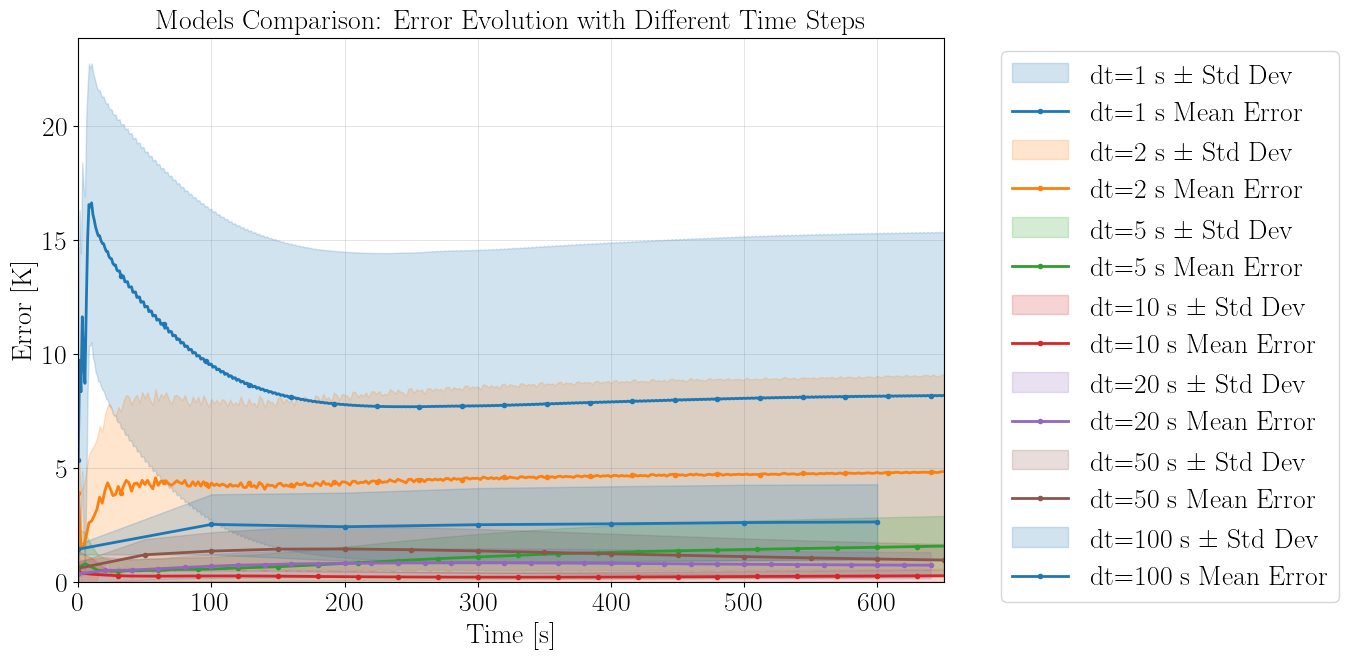


📊 Summary of plotted models:
   - dt=1 s: 651 time steps, dt=1.0000s, range=[0.00, 650.00]s
   - dt=2 s: 326 time steps, dt=2.0000s, range=[0.00, 650.00]s
   - dt=5 s: 131 time steps, dt=5.0000s, range=[0.00, 650.00]s
   - dt=10 s: 66 time steps, dt=10.0000s, range=[0.00, 650.00]s
   - dt=20 s: 33 time steps, dt=20.0000s, range=[0.00, 640.00]s
   - dt=50 s: 14 time steps, dt=50.0000s, range=[0.00, 650.00]s
   - dt=100 s: 7 time steps, dt=100.0000s, range=[0.00, 600.00]s


In [84]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}'
    )

#### Propagating for shorter periods

In [85]:
time_propagated = 200 

In [86]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_propagated // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_propagated, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🔄 Procesando con dt = 100

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 201, 169) (dt=1)
   - T_transient_dt2: (1000, 101, 169) (dt=2)
   - T_transient_dt5: (1000, 41, 169) (dt=5)
   - T_transient_dt10: (1000, 21, 169) (dt=10)
   - T_transient_dt20: (1000, 11, 169) (dt=20)
   - T_transient_dt50: (1000, 5, 169) (dt=50)
   - T_transient_dt100: (1000, 3, 169) (dt=100)


In [87]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_15660\3586809121.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 201
   ⏱️ dt: 1s
   🔗 Sequence length: 201
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [02:34<00:00,  6.46it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 10.222 K
   Overall RMSE: 12.305 K
   Overall STD: 6.727 K
   Initial timestep MAE: 5.384 K
   Final timestep MAE: 7.788 K
   Maximum timestep error: 16.649 K at t=10.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 101
   ⏱️ dt: 2s
   🔗 Sequence length: 101
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:11<00:00, 13.98it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.135 K
   Overall RMSE: 5.500 K
   Overall STD: 3.618 K
   Initial timestep MAE: 3.931 K
   Final timestep MAE: 4.409 K
   Maximum timestep error: 4.594 K at t=58.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 41
   ⏱️ dt: 5s
   🔗 Sequence length: 41
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:29<00:00, 34.30it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.637 K
   Overall RMSE: 0.905 K
   Overall STD: 0.634 K
   Initial timestep MAE: 0.643 K
   Final timestep MAE: 0.837 K
   Maximum timestep error: 0.837 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 21
   ⏱️ dt: 10s
   🔗 Sequence length: 21
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:17<00:00, 57.80it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.293 K
   Overall RMSE: 0.420 K
   Overall STD: 0.292 K
   Initial timestep MAE: 0.439 K
   Final timestep MAE: 0.256 K
   Maximum timestep error: 0.439 K at t=0.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 11
   ⏱️ dt: 20s
   🔗 Sequence length: 11
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:09<00:00, 100.18it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.679 K
   Overall RMSE: 0.879 K
   Overall STD: 0.550 K
   Initial timestep MAE: 0.382 K
   Final timestep MAE: 0.842 K
   Maximum timestep error: 0.842 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 5
   ⏱️ dt: 50s
   🔗 Sequence length: 5
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:05<00:00, 189.34it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.230 K
   Overall RMSE: 1.436 K
   Overall STD: 0.738 K
   Initial timestep MAE: 0.619 K
   Final timestep MAE: 1.473 K
   Maximum timestep error: 1.473 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 3
   ⏱️ dt: 100s
   🔗 Sequence length: 3
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:03<00:00, 270.40it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 2.151 K
   Overall RMSE: 2.405 K
   Overall STD: 1.014 K
   Initial timestep MAE: 1.461 K
   Final timestep MAE: 2.446 K
   Maximum timestep error: 2.548 K at t=100.0s
   Time range: [0.0s, 200.0s]


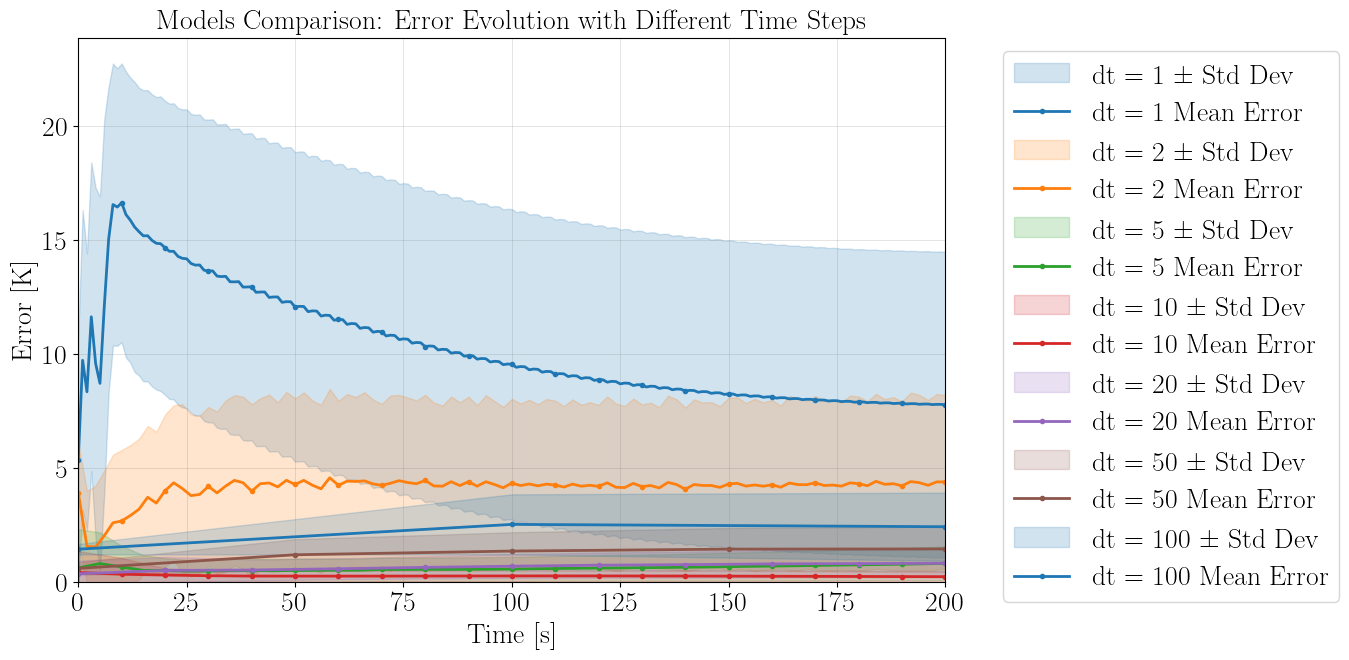


📊 Summary of plotted models:
   - dt = 1: 201 time steps, dt=1.0000s, range=[0.00, 200.00]s
   - dt = 2: 101 time steps, dt=2.0000s, range=[0.00, 200.00]s
   - dt = 5: 41 time steps, dt=5.0000s, range=[0.00, 200.00]s
   - dt = 10: 21 time steps, dt=10.0000s, range=[0.00, 200.00]s
   - dt = 20: 11 time steps, dt=20.0000s, range=[0.00, 200.00]s
   - dt = 50: 5 time steps, dt=50.0000s, range=[0.00, 200.00]s
   - dt = 100: 3 time steps, dt=100.0000s, range=[0.00, 200.00]s


In [88]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}_prop{time_propagated}'
    )

#### Propagating for longer periods

In [89]:
time_propagated = 600 

In [90]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_propagated // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_propagated, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🔄 Procesando con dt = 100

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 601, 169) (dt=1)
   - T_transient_dt2: (1000, 301, 169) (dt=2)
   - T_transient_dt5: (1000, 121, 169) (dt=5)
   - T_transient_dt10: (1000, 61, 169) (dt=10)
   - T_transient_dt20: (1000, 31, 169) (dt=20)
   - T_transient_dt50: (1000, 13, 169) (dt=50)
   - T_transient_dt100: (1000, 7, 169) (dt=100)


In [91]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results



🔄 Procesando con dt = 1 s

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_15660\3586809121.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 601
   ⏱️ dt: 1s
   🔗 Sequence length: 601
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [07:32<00:00,  2.21it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 8.691 K
   Overall RMSE: 11.135 K
   Overall STD: 6.883 K
   Initial timestep MAE: 5.384 K
   Final timestep MAE: 8.156 K
   Maximum timestep error: 16.649 K at t=10.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 301
   ⏱️ dt: 2s
   🔗 Sequence length: 301
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.474 K
   Overall RMSE: 5.960 K
   Overall STD: 3.934 K
   Initial timestep MAE: 3.931 K
   Final timestep MAE: 4.827 K
   Maximum timestep error: 4.827 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 121
   ⏱️ dt: 5s
   🔗 Sequence length: 121
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:29<00:00, 11.20it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.062 K
   Overall RMSE: 1.432 K
   Overall STD: 0.956 K
   Initial timestep MAE: 0.643 K
   Final timestep MAE: 1.545 K
   Maximum timestep error: 1.545 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 61
   ⏱️ dt: 10s
   🔗 Sequence length: 61
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:47<00:00, 20.88it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.265 K
   Overall RMSE: 0.365 K
   Overall STD: 0.248 K
   Initial timestep MAE: 0.439 K
   Final timestep MAE: 0.285 K
   Maximum timestep error: 0.439 K at t=0.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 31
   ⏱️ dt: 20s
   🔗 Sequence length: 31
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:24<00:00, 41.36it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.773 K
   Overall RMSE: 0.975 K
   Overall STD: 0.590 K
   Initial timestep MAE: 0.382 K
   Final timestep MAE: 0.768 K
   Maximum timestep error: 0.862 K at t=280.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 13
   ⏱️ dt: 50s
   🔗 Sequence length: 13
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:10<00:00, 93.10it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.230 K
   Overall RMSE: 1.476 K
   Overall STD: 0.814 K
   Initial timestep MAE: 0.619 K
   Final timestep MAE: 1.029 K
   Maximum timestep error: 1.473 K at t=200.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 7
   ⏱️ dt: 100s
   🔗 Sequence length: 7
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:06<00:00, 160.18it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 2.406 K
   Overall RMSE: 2.786 K
   Overall STD: 1.372 K
   Initial timestep MAE: 1.461 K
   Final timestep MAE: 2.655 K
   Maximum timestep error: 2.655 K at t=600.0s
   Time range: [0.0s, 600.0s]


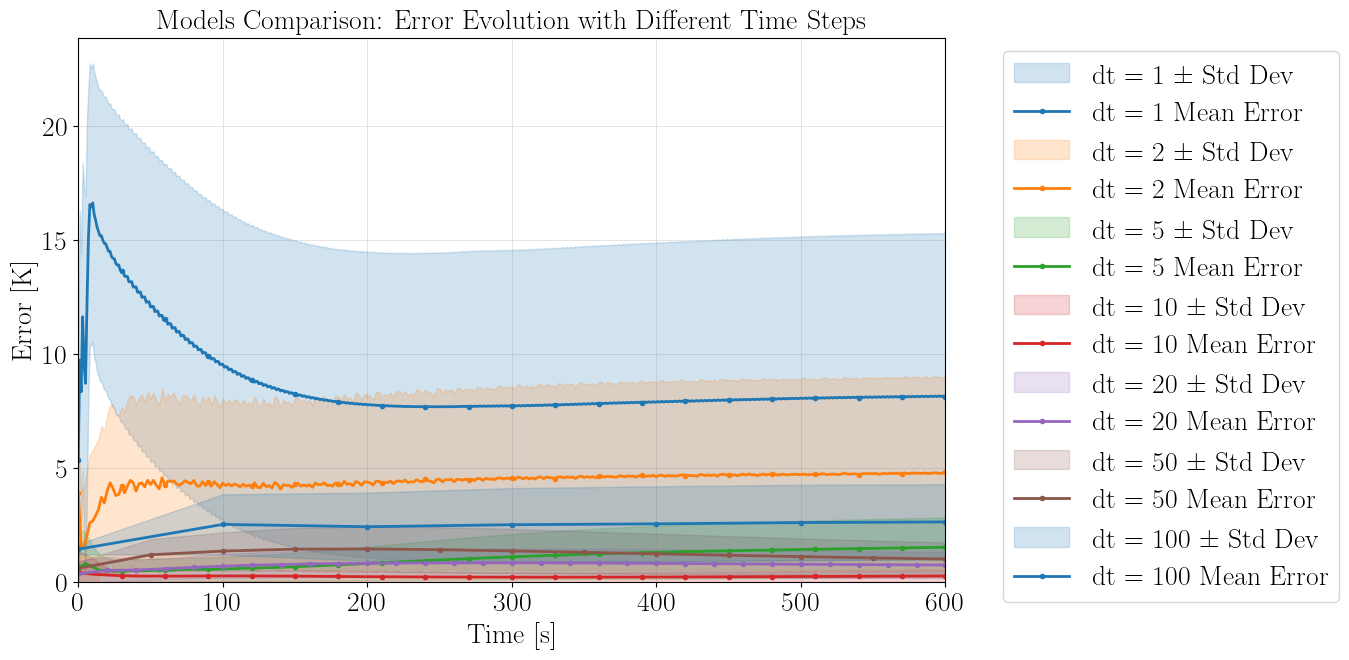


📊 Summary of plotted models:
   - dt = 1: 601 time steps, dt=1.0000s, range=[0.00, 600.00]s
   - dt = 2: 301 time steps, dt=2.0000s, range=[0.00, 600.00]s
   - dt = 5: 121 time steps, dt=5.0000s, range=[0.00, 600.00]s
   - dt = 10: 61 time steps, dt=10.0000s, range=[0.00, 600.00]s
   - dt = 20: 31 time steps, dt=20.0000s, range=[0.00, 600.00]s
   - dt = 50: 13 time steps, dt=50.0000s, range=[0.00, 600.00]s
   - dt = 100: 7 time steps, dt=100.0000s, range=[0.00, 600.00]s


In [92]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}_prop{time_propagated}'
    )

### Time_sim = 200

#### Simulation of a number of cases for comparison

In [93]:
# n_data = 10          # Número de casos a analizar
time_sim = 200         # Tiempo máximo de simulación [s]
# dt_values = [1, 2, 5, 10, 20, 50, 100]                  # Paso temporal [s]
# Calculate sequence length for each dt value in the list
sequence_lengths = [time_sim // dt + 1 for dt in dt_values]
# T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   ⏱️  Longitud de secuencia: {sequence_lengths} pasos")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 1000
   ⏱️  Tiempo máximo: 200s
   ⏱️  Longitud de secuencia: [201, 101, 41, 21, 11, 5, 3] pasos


In [94]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_sim // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_sim, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🔄 Procesando con dt = 100

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 201, 169) (dt=1)
   - T_transient_dt2: (1000, 101, 169) (dt=2)
   - T_transient_dt5: (1000, 41, 169) (dt=5)
   - T_transient_dt10: (1000, 21, 169) (dt=10)
   - T_transient_dt20: (1000, 11, 169) (dt=20)
   - T_transient_dt50: (1000, 5, 169) (dt=50)
   - T_transient_dt100: (1000, 3, 169) (dt=100)


#### Different dt

In [95]:
# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)
batch_size = 64                            # Tamaño de batch
n_train = 1000                            # Número de casos de entrenamiento

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden
    

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

model_dir = os.path.join(BASE_PATH, 'models', 'ConvLSTM_6ch', 'stateful_O2O')

In [96]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}
# dt_values = [2, 5, 10, 20, 50, 100]

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_15660\2164224697.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 201
   ⏱️ dt: 1s
   🔗 Sequence length: 201
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.619 K
   Overall RMSE: 2.184 K
   Overall STD: 1.457 K
   Initial timestep MAE: 1.176 K
   Final timestep MAE: 1.974 K
   Maximum timestep error: 1.974 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 101
   ⏱️ dt: 2s
   🔗 Sequence length: 101
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:15<00:00, 13.23it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.490 K
   Overall RMSE: 3.125 K
   Overall STD: 2.745 K
   Initial timestep MAE: 1.389 K
   Final timestep MAE: 1.735 K
   Maximum timestep error: 1.735 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 41
   ⏱️ dt: 5s
   🔗 Sequence length: 41
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:31<00:00, 31.61it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.127 K
   Overall RMSE: 0.184 K
   Overall STD: 0.131 K
   Initial timestep MAE: 0.120 K
   Final timestep MAE: 0.190 K
   Maximum timestep error: 0.190 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 21
   ⏱️ dt: 10s
   🔗 Sequence length: 21
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:16<00:00, 61.17it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.180 K
   Overall RMSE: 0.241 K
   Overall STD: 0.159 K
   Initial timestep MAE: 0.168 K
   Final timestep MAE: 0.170 K
   Maximum timestep error: 0.241 K at t=10.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 11
   ⏱️ dt: 20s
   🔗 Sequence length: 11
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:08<00:00, 113.80it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.399 K
   Overall RMSE: 0.511 K
   Overall STD: 0.320 K
   Initial timestep MAE: 0.314 K
   Final timestep MAE: 0.442 K
   Maximum timestep error: 0.442 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 5
   ⏱️ dt: 50s
   🔗 Sequence length: 5
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:04<00:00, 217.62it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.762 K
   Overall RMSE: 0.919 K
   Overall STD: 0.500 K
   Initial timestep MAE: 0.627 K
   Final timestep MAE: 0.843 K
   Maximum timestep error: 0.843 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 3
   ⏱️ dt: 100s
   🔗 Sequence length: 3
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:03<00:00, 316.98it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.752 K
   Overall RMSE: 1.984 K
   Overall STD: 0.842 K
   Initial timestep MAE: 1.541 K
   Final timestep MAE: 1.869 K
   Maximum timestep error: 1.869 K at t=200.0s
   Time range: [0.0s, 200.0s]


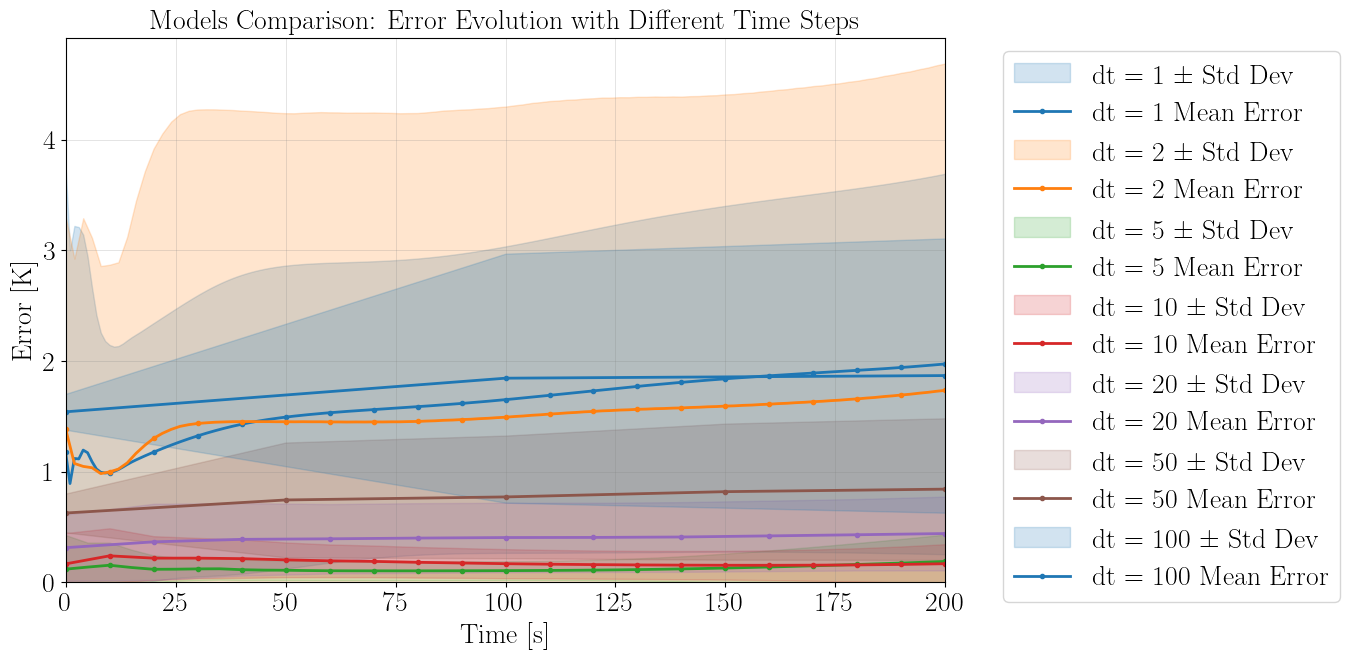


📊 Summary of plotted models:
   - dt = 1: 201 time steps, dt=1.0000s, range=[0.00, 200.00]s
   - dt = 2: 101 time steps, dt=2.0000s, range=[0.00, 200.00]s
   - dt = 5: 41 time steps, dt=5.0000s, range=[0.00, 200.00]s
   - dt = 10: 21 time steps, dt=10.0000s, range=[0.00, 200.00]s
   - dt = 20: 11 time steps, dt=20.0000s, range=[0.00, 200.00]s
   - dt = 50: 5 time steps, dt=50.0000s, range=[0.00, 200.00]s
   - dt = 100: 3 time steps, dt=100.0000s, range=[0.00, 200.00]s


In [97]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}'
    )

#### Propagating for longer periods

In [98]:
time_propagated = 600 

In [99]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_propagated // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_propagated, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🔄 Procesando con dt = 100

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 601, 169) (dt=1)
   - T_transient_dt2: (1000, 301, 169) (dt=2)
   - T_transient_dt5: (1000, 121, 169) (dt=5)
   - T_transient_dt10: (1000, 61, 169) (dt=10)
   - T_transient_dt20: (1000, 31, 169) (dt=20)
   - T_transient_dt50: (1000, 13, 169) (dt=50)
   - T_transient_dt100: (1000, 7, 169) (dt=100)


In [100]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_15660\3586809121.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 601
   ⏱️ dt: 1s
   🔗 Sequence length: 601
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.198 K
   Overall RMSE: 4.991 K
   Overall STD: 2.652 K
   Initial timestep MAE: 1.176 K
   Final timestep MAE: 9.377 K
   Maximum timestep error: 9.377 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 301
   ⏱️ dt: 2s
   🔗 Sequence length: 301
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 3.100 K
   Overall RMSE: 5.159 K
   Overall STD: 4.092 K
   Initial timestep MAE: 1.389 K
   Final timestep MAE: 5.949 K
   Maximum timestep error: 5.949 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 121
   ⏱️ dt: 5s
   🔗 Sequence length: 121
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:30<00:00, 11.04it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.126 K
   Overall RMSE: 2.390 K
   Overall STD: 2.103 K
   Initial timestep MAE: 0.120 K
   Final timestep MAE: 3.942 K
   Maximum timestep error: 3.942 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 61
   ⏱️ dt: 10s
   🔗 Sequence length: 61
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:46<00:00, 21.51it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.576 K
   Overall RMSE: 0.795 K
   Overall STD: 0.547 K
   Initial timestep MAE: 0.168 K
   Final timestep MAE: 1.454 K
   Maximum timestep error: 1.454 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 31
   ⏱️ dt: 20s
   🔗 Sequence length: 31
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:24<00:00, 40.83it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.449 K
   Overall RMSE: 1.855 K
   Overall STD: 1.157 K
   Initial timestep MAE: 0.314 K
   Final timestep MAE: 4.274 K
   Maximum timestep error: 4.274 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 13
   ⏱️ dt: 50s
   🔗 Sequence length: 13
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:10<00:00, 93.44it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 3.165 K
   Overall RMSE: 4.893 K
   Overall STD: 3.686 K
   Initial timestep MAE: 0.627 K
   Final timestep MAE: 9.497 K
   Maximum timestep error: 9.497 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 7
   ⏱️ dt: 100s
   🔗 Sequence length: 7
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:06<00:00, 159.40it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 7.355 K
   Overall RMSE: 9.071 K
   Overall STD: 5.247 K
   Initial timestep MAE: 1.541 K
   Final timestep MAE: 19.544 K
   Maximum timestep error: 19.544 K at t=600.0s
   Time range: [0.0s, 600.0s]


### Time_sim = 50

#### Simulation of a number of cases for comparison

In [101]:
# n_data = 10          # Número de casos a analizar
time_sim = 50         # Tiempo máximo de simulación [s]
dt_values = [1, 2, 5, 10, 50]                  # Paso temporal [s]
# Calculate sequence length for each dt value in the list
sequence_lengths = [time_sim // dt + 1 for dt in dt_values]
# T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   ⏱️  Longitud de secuencia: {sequence_lengths} pasos")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 1000
   ⏱️  Tiempo máximo: 50s
   ⏱️  Longitud de secuencia: [51, 26, 11, 6, 2] pasos


In [102]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_sim // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_sim, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 50

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 51, 169) (dt=1)
   - T_transient_dt2: (1000, 26, 169) (dt=2)
   - T_transient_dt5: (1000, 11, 169) (dt=5)
   - T_transient_dt10: (1000, 6, 169) (dt=10)
   - T_transient_dt50: (1000, 2, 169) (dt=50)


#### Different dt

In [103]:
# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)
batch_size = 64                            # Tamaño de batch
n_train = 1000                            # Número de casos de entrenamiento

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden
    

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

model_dir = os.path.join(BASE_PATH, 'models', 'ConvLSTM_6ch', 'stateful_O2O')

In [104]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}
# dt_values = [2, 5, 10, 20, 50, 100]

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_15660\2164224697.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 51
   ⏱️ dt: 1s
   🔗 Sequence length: 51
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:39<00:00, 25.59it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.064 K
   Overall RMSE: 0.097 K
   Overall STD: 0.072 K
   Initial timestep MAE: 0.090 K
   Final timestep MAE: 0.111 K
   Maximum timestep error: 0.111 K at t=50.0s
   Time range: [0.0s, 50.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 26
   ⏱️ dt: 2s
   🔗 Sequence length: 26
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:20<00:00, 49.38it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.106 K
   Overall RMSE: 0.249 K
   Overall STD: 0.225 K
   Initial timestep MAE: 0.060 K
   Final timestep MAE: 0.155 K
   Maximum timestep error: 0.155 K at t=50.0s
   Time range: [0.0s, 50.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 11
   ⏱️ dt: 5s
   🔗 Sequence length: 11
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:09<00:00, 103.63it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.082 K
   Overall RMSE: 0.124 K
   Overall STD: 0.092 K
   Initial timestep MAE: 0.082 K
   Final timestep MAE: 0.085 K
   Maximum timestep error: 0.088 K at t=5.0s
   Time range: [0.0s, 50.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 6
   ⏱️ dt: 10s
   🔗 Sequence length: 6
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:05<00:00, 178.48it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.179 K
   Overall RMSE: 0.294 K
   Overall STD: 0.230 K
   Initial timestep MAE: 0.155 K
   Final timestep MAE: 0.229 K
   Maximum timestep error: 0.229 K at t=50.0s
   Time range: [0.0s, 50.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 2
   ⏱️ dt: 50s
   🔗 Sequence length: 2
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:02<00:00, 400.47it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.649 K
   Overall RMSE: 0.755 K
   Overall STD: 0.371 K
   Initial timestep MAE: 0.646 K
   Final timestep MAE: 0.651 K
   Maximum timestep error: 0.651 K at t=50.0s
   Time range: [0.0s, 50.0s]


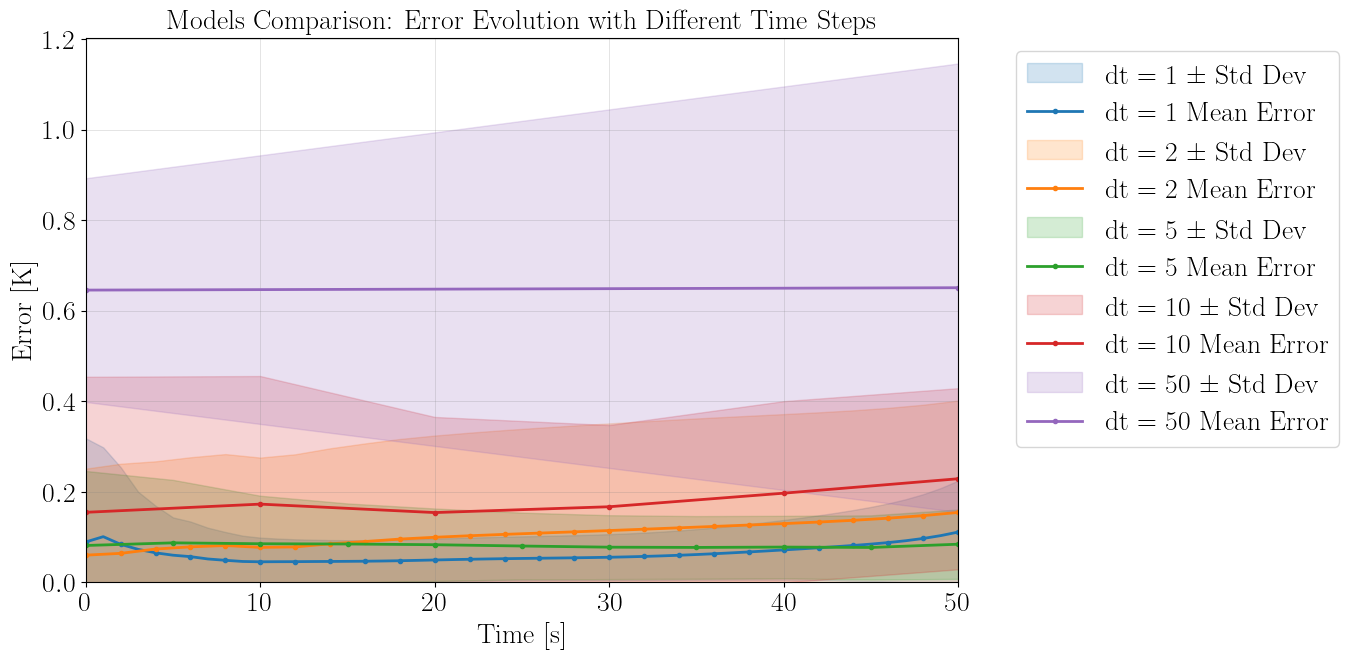


📊 Summary of plotted models:
   - dt = 1: 51 time steps, dt=1.0000s, range=[0.00, 50.00]s
   - dt = 2: 26 time steps, dt=2.0000s, range=[0.00, 50.00]s
   - dt = 5: 11 time steps, dt=5.0000s, range=[0.00, 50.00]s
   - dt = 10: 6 time steps, dt=10.0000s, range=[0.00, 50.00]s
   - dt = 50: 2 time steps, dt=50.0000s, range=[0.00, 50.00]s


In [105]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}'
    )

#### Propagating for longer periods

In [106]:
time_propagated = 650 

In [107]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_propagated // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_propagated, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 50

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 651, 169) (dt=1)
   - T_transient_dt2: (1000, 326, 169) (dt=2)
   - T_transient_dt5: (1000, 131, 169) (dt=5)
   - T_transient_dt10: (1000, 66, 169) (dt=10)
   - T_transient_dt50: (1000, 14, 169) (dt=50)


In [108]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_15660\3586809121.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 651
   ⏱️ dt: 1s
   🔗 Sequence length: 651
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 7.654 K
   Overall RMSE: 8.837 K
   Overall STD: 4.412 K
   Initial timestep MAE: 0.090 K
   Final timestep MAE: 10.609 K
   Maximum timestep error: 10.609 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 326
   ⏱️ dt: 2s
   🔗 Sequence length: 326
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [04:06<00:00,  4.06it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 6.247 K
   Overall RMSE: 8.391 K
   Overall STD: 5.597 K
   Initial timestep MAE: 0.060 K
   Final timestep MAE: 11.592 K
   Maximum timestep error: 11.592 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 131
   ⏱️ dt: 5s
   🔗 Sequence length: 131
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:40<00:00,  9.97it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 5.145 K
   Overall RMSE: 6.342 K
   Overall STD: 3.672 K
   Initial timestep MAE: 0.082 K
   Final timestep MAE: 9.109 K
   Maximum timestep error: 9.109 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 66
   ⏱️ dt: 10s
   🔗 Sequence length: 66
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:51<00:00, 19.39it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 6.994 K
   Overall RMSE: 8.633 K
   Overall STD: 5.046 K
   Initial timestep MAE: 0.155 K
   Final timestep MAE: 8.885 K
   Maximum timestep error: 9.734 K at t=620.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 14
   ⏱️ dt: 50s
   🔗 Sequence length: 14
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:12<00:00, 83.29it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 14.541 K
   Overall RMSE: 17.709 K
   Overall STD: 9.885 K
   Initial timestep MAE: 0.646 K
   Final timestep MAE: 21.405 K
   Maximum timestep error: 22.105 K at t=500.0s
   Time range: [0.0s, 650.0s]


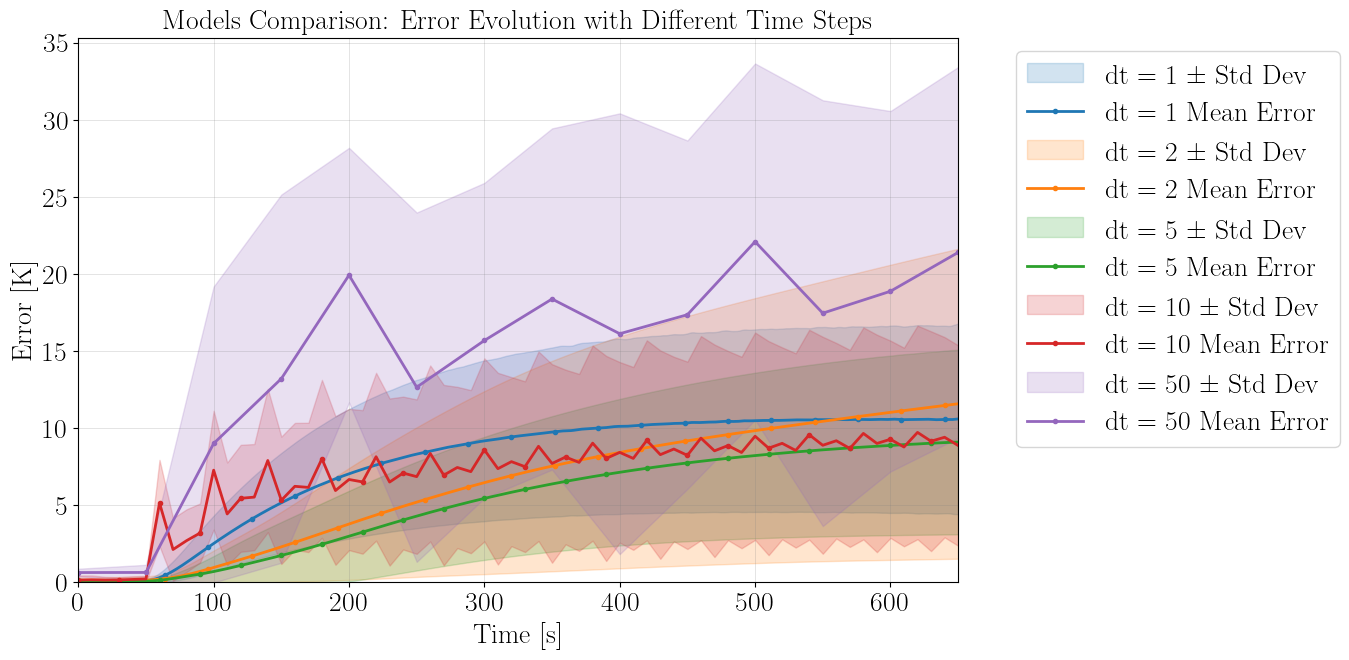


📊 Summary of plotted models:
   - dt = 1: 651 time steps, dt=1.0000s, range=[0.00, 650.00]s
   - dt = 2: 326 time steps, dt=2.0000s, range=[0.00, 650.00]s
   - dt = 5: 131 time steps, dt=5.0000s, range=[0.00, 650.00]s
   - dt = 10: 66 time steps, dt=10.0000s, range=[0.00, 650.00]s
   - dt = 50: 14 time steps, dt=50.0000s, range=[0.00, 650.00]s


In [109]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}_prop{time_propagated}'
    )

## Comparison for different weights of physics-loss terms

### Simulation of different cases

In [ ]:
n_data = 10          # Número de casos a analizar
n_train = 200
time_sim = 650         # Tiempo máximo de simulación [s]
dt = 10                 # Paso temporal [s]
# Calculate sequence length for each dt value in the list
sequence_length = time_sim // dt + 1 
T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   ⏱️  Longitud de secuencia: {sequence_lengths} pasos")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 10
   ⏱️  Tiempo máximo: 650s
   ⏱️  Longitud de secuencia: [51, 26, 11, 6, 2] pasos


In [ ]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))

for i in range(n_data):
    if i % 100 == 0:  # Progress indicator
        print(f"   📊 Procesando caso {i}/{n_data}...")
        
    # Condiciones para este caso
    Q = Q_random[i]
    T_int = T_interfaces_random[i]
    T_env = T_env_random[i]
    
    # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
    T_transient, _, _, _ = PCB_case_2(
        solver='transient', display=False, time=time_sim, dt=1,
        T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
    )
    
    T_transient_dt = downsample_solver_output(T_transient, dt)
    
    # Almacenar resultado
    T_true_all[i] = T_transient_dt

print(f"🎉 Análisis completado!")
print(f"📦 Array de temperaturas: {T_true_all.shape}")
print(f"   - {n_data} casos")
print(f"   - {sequence_length} pasos temporales")
print(f"   - {spatial_nodes} nodos espaciales")

   📊 Procesando caso 0/10...
🎉 Análisis completado!
📦 Array de temperaturas: (10, 66, 169)
   - 10 casos
   - 66 pasos temporales
   - 169 nodos espaciales


### Import of the models required

In [ ]:
mse_weights = [1.0, 0.0]
phy_weights = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e2, 1e3]
bnd_weights = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e2, 1e3]

In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results_phy = {}
total_combinations = len(mse_weights) * len(phy_weights) * len(bnd_weights)
case_counter = 0

# Iterar sobre combinaciones de pesos de física
for mse_w in mse_weights:
    for phy_w in phy_weights:
        for bnd_w in bnd_weights:
            case_counter += 1
            print(f"\n🔄 [{case_counter}/{total_combinations}] Procesando MSE={mse_w}, PHY={phy_w}, BND={bnd_w}")
            
            # Construir nombre del archivo del modelo
            filename = (f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_"
                       f"h{layer_string}_k{kernel_string}_mse{mse_w}_phy{phy_w}_bnd{bnd_w}.pth")
            model_path = os.path.join(model_dir, filename)
            
            # Verificar si el modelo existe
            if not os.path.exists(model_path):
                print(f"⚠️ [{case_counter}/{total_combinations}] Modelo no encontrado: {filename}")
                continue
            
            try:
                # Cargar modelo
                model.load_state_dict(torch.load(model_path, map_location=device))
                model.eval()
                
                # Llamar función de evaluación
                results_name = f'MSE={mse_w}, PHY={phy_w}, BND={bnd_w}'
                results = calculate_convlstm_error_by_timestep(
                    model=model,
                    dataset=dataset_phy,
                    T_transient_all=T_true_all,
                    Q_cases=Q_random,
                    T_interfaces_cases=T_interfaces_random,
                    T_env_cases=T_env_random,
                    dt=dt,
                    device=device,
                    sequence_length=sequence_length,
                    display=False
                )
                
                comparison_results_phy[results_name] = results
                print(f"✅ Evaluado: {results_name}")
                
            except Exception as e:
                print(f"❌ Error evaluando {filename}: {e}")
                continue

print(f"\n🎉 Evaluación completada para {len(comparison_results_phy)}/{total_combinations} modelos con física")


🔄 [1/162] Procesando MSE=1.0, PHY=0.0, BND=0.0


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_15660\4293954076.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.0

🔄 [2/162] Procesando MSE=1.0, PHY=0.0, BND=1e-05
✅ Evaluado: MSE=1.0, PHY=0.0, BND=1e-05

🔄 [3/162] Procesando MSE=1.0, PHY=0.0, BND=0.0001
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.0001

🔄 [4/162] Procesando MSE=1.0, PHY=0.0, BND=0.001
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.001

🔄 [5/162] Procesando MSE=1.0, PHY=0.0, BND=0.01
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.01

🔄 [6/162] Procesando MSE=1.0, PHY=0.0, BND=0.1
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.1

🔄 [7/162] Procesando MSE=1.0, PHY=0.0, BND=1.0
✅ Evaluado: MSE=1.0, PHY=0.0, BND=1.0

🔄 [8/162] Procesando MSE=1.0, PHY=0.0, BND=100.0
✅ Evaluado: MSE=1.0, PHY=0.0, BND=100.0

🔄 [9/162] Procesando MSE=1.0, PHY=0.0, BND=1000.0
✅ Evaluado: MSE=1.0, PHY=0.0, BND=1000.0

🔄 [10/162] Procesando MSE=1.0, PHY=1e-05, BND=0.0
✅ Evaluado: MSE=1.0, PHY=1e-05, BND=0.0

🔄 [11/162] Procesando MSE=1.0, PHY=1e-05, BND=1e-05
✅ Evaluado: MSE=1.0, PHY=1e-05, BND=1e-05

🔄 [12/162] Procesando MSE=1.0, PHY=1e-05, BND=0.0001
✅ Evalua

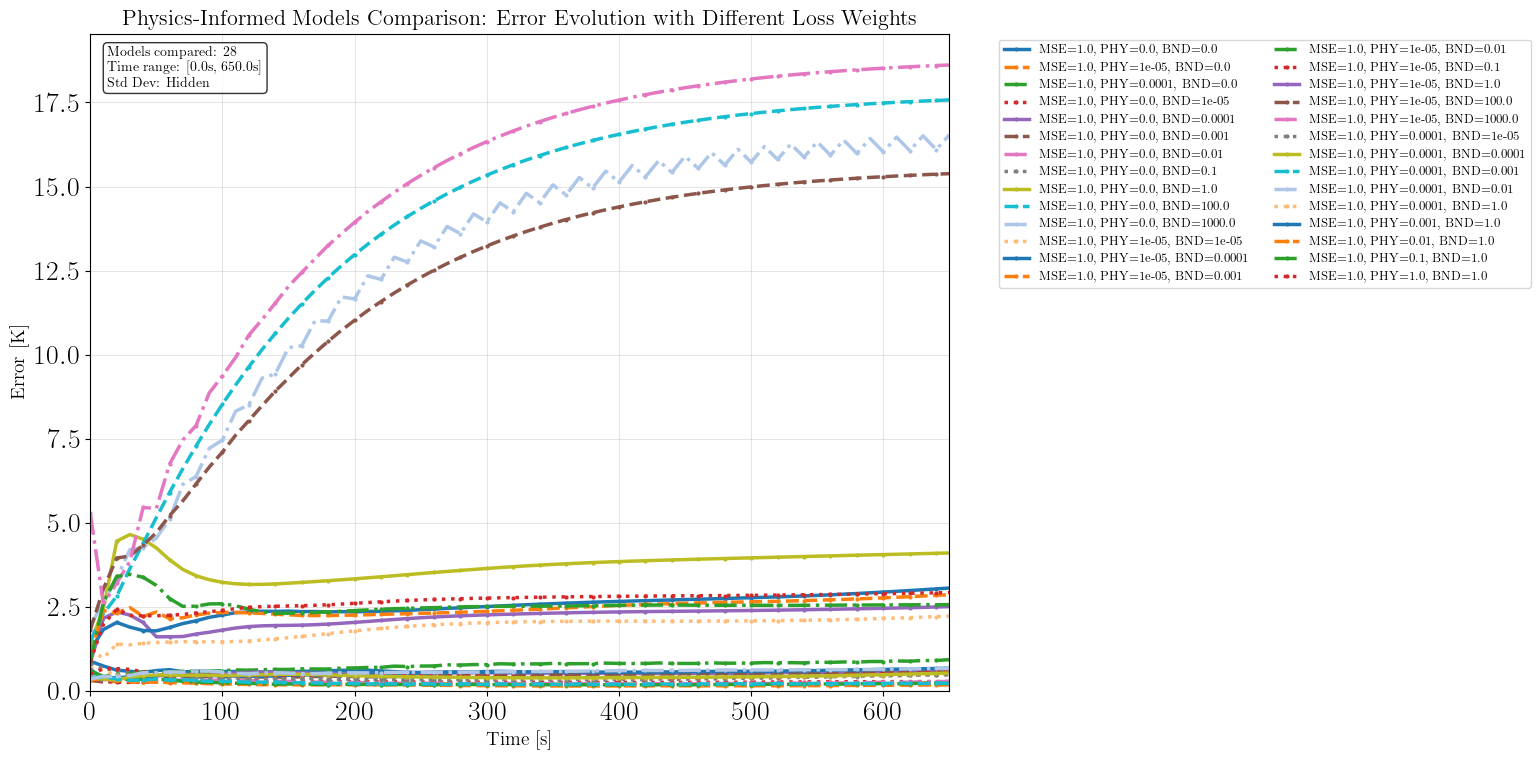


🏆 PHYSICS MODELS RANKING (Ordered by Overall MAE - Best to Worst)
Rank Model Configuration                 Overall MAE  Overall RMSE  Final MAE    Improvement 
----------------------------------------------------------------------------------------------------
1    MSE=1.0, PHY=1e-05, BND=0.001       0.1766       0.2296        0.1756       +68.9%      
2    MSE=1.0, PHY=1e-05, BND=0.0         0.2126       0.2776        0.2422       +62.5%      
3    MSE=1.0, PHY=1e-05, BND=0.01        0.2162       0.2810        0.2168       +61.9%      
4    MSE=1.0, PHY=0.0001, BND=0.001      0.2301       0.3069        0.2189       +59.5%      
5    MSE=1.0, PHY=0.0, BND=0.01          0.2489       0.3222        0.2810       +56.1%      
6    MSE=1.0, PHY=0.0, BND=1e-05         0.2642       0.3423        0.2738       +53.5%      
7    MSE=1.0, PHY=0.0, BND=0.1           0.3903       0.5131        0.4778       +31.2%      
8    MSE=1.0, PHY=0.0001, BND=1e-05      0.4081       0.5357        0.4807      

In [ ]:
# Usar la función adaptada
if comparison_results_phy:
    plot_physics_models_comparison_with_std_bands(
        comparison_results_phy, 
        save_as_pdf=True, 
        filename=f'models_comparison_physics_time{time_sim}_dt{dt}_nt{n_train}'
    )

In [ ]:
# Función normal con error máximo incluido
print_physics_models_ranking(comparison_results_phy)

In [ ]:
# Función detallada con rankings separados
print_physics_models_ranking_detailed(comparison_results_phy)